In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statistics
from datetime import datetime, timedelta

In [302]:
import warnings
warnings.filterwarnings('ignore')

## Contents

* [Part 0. General task description](#desc)
* [Part 1. Prepare and explore the data](#prepare)
    * [Import data](#import)
    * [Data exploration](#DEA)
    * [Data preparation](#prep)
    * [1.1 Unique users by hours, trend and season visualisation](#user_trend)
        * [Plot the trend and the season](#trend)
    * [1.2 Level time](#level_time)
        * [Plot amount of users by max level](#level_max)
        * [Visualisations user level by time](#level_vis)
* [Part 2. Global retention for all users by days in app](#global_ret)
    * [Global retention](#global_ret_calc)
    * [Plot global retention chart](#global_ret_plot)
    * [Global retention heat map](#global_ret_heat_map)
        * [Construct the table by start day](#global_ret_table)
        * [Plot the heat map - users by start day](#global_ret_hm_plot)
* [Part 3. Plot retention by A/B groups and categories](#to_functions)
    * [A/B/ groups retentions](#ab)
        * [Functions to calculate and plot retentions by groups](#func)
        * [Split A/B groups by version of app](#split)
        * [Get retention and check the balance](#get_ret)
        * [Plot retentions by days for A/B groups](#ret_plot_ab)
    * [Divide users by countries](#div_country)
        * [Get dictionary for every group in in some category](#to_dict)
        * [Plot unnormalized data to visually check](#ret_plot_abs)
        * [Plot normalized data to compare](#ret_plot_norm)
        * [Compare A/B groups within one country](#compare_in_cat)
    * [Group Exception vs Others](#ex_vs_others)
        * [Plot retention for 4 groups](#plot_4_ret)
    * [Compare by device manufacturer](#by_device)
    * [Samsung vs top 10 after S.](#sam_to10)
        * [Plots Samsung vs 10 after S.](#sam_to10_plot)
* [Part 4. Separated cohorts, statistical tests](#sep_cohorts)
    * [Retention for different groups, by days](#ret_days_all)
    * [Updated retention functions, keepeng cohorts data](#upd_func)
    * [Filter by category, keeping the day (US/exUS)](#cat_filter)
        * [Get Others vs Exception, keeping the day](#ot_exc_day)
        * [Plot the retentions from the chosen day](#day_plot)
        * [Mann–Whitney U tests](#tests)
    * [Device groups - Samsung vs 10 top after Samsung](#day_samto10)
        * [Plots Samsung and Others by days](#day_sam_plots)
        * [Statistical tests for Samsung vs 10 top after S.](#day_sam_tests)
    * [Conclusion](#conc_4)
    * [4.1 Explore Samsung group by countries](#samsung_part)
        * [Plots for Samsung group](#sam_plots)
        * [Mann–Whitney U tests for Samsung users](#sam_tests)
        * [Conclusion](#sam_conc)
* [Part 5. Retention heat maps](#heat_maps)
    * [Retention heat maps for all users](#hm_all_users)
        * [Construct the table](#table_cons)
        * [Plot heat maps](#hm_global)
    * [heat maps for Exception vs Others](#hm_ex_others)
        * [Plot heat maps (Cartesian product of A/B, Exception/Others)](#hm_plot)
        * [The differences by heat maps](#hm_diff)
        * [Plot heat maps](#hm_diff_plot)
    * [5.1 Samsung retention heat maps (US/exUS subgroups)](#samsung_heat_maps)
        * [Plot four heat maps absolute, normalized](#hm_sam_abs)
        * [Plot the differences by heat map in Samsung group](#hm_sam_diff)
        * [Conclusion](#5_conc)
* [General conclusion](#gen_conc)
* [Next steps](#next)

# 0. General task description <a class="anchor" id="desc"></a>


We have the mobile game (application). There are many users playing level by level, all over the world.<br>
After deployment of the new application version we want to be sure everything working properly. If everything going well and there are no serious deviations in different groups (by country and by device), we can to allow to all users migrating to the new one.<br>
To achieve that the following steps will be done:
* Create functions to filter data by groups and subgroups
* Explore users behaviour in different groups and subgroups
* Calculate retentions for different groups of `Unique users`
* Check groups or subgroups trends by:
    * plotting graphs and heat maps of retention (in absolute values and normalized)
    * statisctical tests between groups after normalization<br>
    
<i>If some trend deviation exist it could be an issue with new app</i>
<br>There is a lot of data in our logs, important to remember that the scope of work here is amount of users, retention.
<br>Will use pandas, matplotlib, scipy, statsmodels.

# Part 1. Prepare and explore the data <a class="anchor" id="prepare"></a>

### Import dataset <a class="anchor" id="import"></a>

In [303]:
# local import
globe_normal = pd.read_csv('globe_normal.csv')

### Data exploration <a class="anchor" id="DEA"></a>

In [304]:
# for obvious reasons all the data can't be showed as is, will use this function to show raw data with id field cleaned
def can_show(df):
    df_to_show = df.head()
    df_to_show['appmetrica_device_id'] = '000000000'
    return df_to_show

In [305]:
# show the head of the table without id
can_show(globe_normal)

level_number  level_count level_random   coins  room_num  room_progress  \
0          36.0         40.0        False  4183.0       0.0            1.0   
1          37.0         41.0        False  4294.0       0.0            1.0   
2          37.0         42.0        False  4294.0       0.0            1.0   
3          38.0         43.0        False  4417.0       0.0            1.0   
4           1.0          1.0        False    50.0       0.0            0.0   

   room_objects  level_diff appmetrica_device_id       event_datetime  \
0           7.0         NaN            000000000  2022-05-30 00:08:42   
1           7.0         NaN            000000000  2022-05-30 00:18:13   
2           7.0         NaN            000000000  2022-05-30 00:23:37   
3           7.0         NaN            000000000  2022-05-30 00:35:57   
4           7.0         NaN            000000000  2022-05-30 05:27:42   

  device_manufacturer country_iso_code  app_version_name  
0             Samsung               AR              23.0  
1             Samsung               AR              23.0  
2             Samsung               AR              23.0  
3             Samsung               AR              23.0  
4             Samsung               IT              23.0

In [306]:
globe_normal.shape

(581076, 13)

In [307]:
# get info | check date format
globe_normal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581076 entries, 0 to 581075
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   level_number          581076 non-null  float64
 1   level_count           581076 non-null  float64
 2   level_random          580942 non-null  object 
 3   coins                 553439 non-null  float64
 4   room_num              553439 non-null  float64
 5   room_progress         553439 non-null  float64
 6   room_objects          553439 non-null  float64
 7   level_diff            27503 non-null   float64
 8   appmetrica_device_id  581076 non-null  uint64 
 9   event_datetime        581076 non-null  object 
 10  device_manufacturer   581076 non-null  object 
 11  country_iso_code      581050 non-null  object 
 12  app_version_name      581076 non-null  float64
dtypes: float64(8), object(4), uint64(1)
memory usage: 57.6+ MB


In [308]:
globe_normal.country_iso_code.isnull().sum() # okay, some persons have no country data, very low number

26

In [309]:
globe_normal.describe()

level_number    level_count          coins       room_num  \
count  581076.000000  581076.000000  553439.000000  553439.000000   
mean       71.835911     201.110839    7039.658260       0.112507   
std       236.875499     628.211790   25912.658122       0.954920   
min         1.000000       1.000000       0.000000       0.000000   
25%         7.000000       8.000000     298.000000       0.000000   
50%        19.000000      26.000000    1505.000000       0.000000   
75%        44.000000      89.000000    4903.000000       0.000000   
max      3728.000000    6646.000000  706457.000000      32.000000   

       room_progress   room_objects    level_diff  appmetrica_device_id  \
count  553439.000000  553439.000000  27503.000000          5.810760e+05   
mean        0.429319       7.060973     48.883358          9.356612e+18   
std         1.140104       0.343390      9.961295          5.353624e+18   
min         0.000000       6.000000      3.000000          4.316371e+14   
25%         0.000000       7.000000     46.000000          4.728531e+18   
50%         0.000000       7.000000     52.000000          9.350714e+18   
75%         0.000000       7.000000     55.000000          1.411902e+19   
max         9.000000       9.000000     61.000000          1.844614e+19   

       app_version_name  
count     581076.000000  
mean          22.388097  
std            1.448137  
min            6.000000  
25%           22.400000  
50%           22.400000  
75%           23.000000  
max           23.000000

### Data preparation <a class="anchor" id="prep"></a>

We will drop the columns which are not in scope of our interest for now

In [310]:
# option to drop more columns
globe_normal = globe_normal.drop(['level_count', 'level_random', 'coins', 'room_num', 'room_progress', 'room_objects', 'level_diff'], axis=1)

We will explore two versions of application 22.4 and 23.0 (the new one), so will drop another versions

In [311]:
# list of versions
globe_normal.app_version_name.unique()

array([23. , 22.4, 14. , 17. , 19. , 21. , 15. , 20. , 11. ,  7. , 10. ,
       22.2, 22.3,  6. ,  9. ,  8. , 12. , 18. , 13. ])

In [312]:
# check version auditory
globe_normal.app_version_name.value_counts()

22.4    280051
23.0    260629
21.0     12741
20.0     10313
19.0      5344
17.0      3927
14.0      2887
11.0      2243
10.0       867
15.0       658
12.0       379
9.0        355
18.0       224
6.0        134
7.0        103
8.0        102
13.0       101
22.2        10
22.3         8
Name: app_version_name, dtype: int64

In [313]:
# get rid of another versions (out of test)
globe_normal = globe_normal[(globe_normal.app_version_name == 22.4) | (globe_normal.app_version_name == 23)]
globe_normal.app_version_name.unique()

array([23. , 22.4])

In [314]:
# number of unique users in set (to check integrity after transformations)
total_users = globe_normal.appmetrica_device_id.nunique()
total_users

27636

Will assign dates to events 

In [315]:
# get event date from timestamp
globe_normal['event_date'] = pd.to_datetime(globe_normal.event_datetime).apply(lambda x: x.strftime('%Y-%m-%d'))
globe_normal['event_date'] = pd.to_datetime(globe_normal['event_date'])
globe_normal.event_date.head(3)

0   2022-05-30
1   2022-05-30
2   2022-05-30
Name: event_date, dtype: datetime64[ns]

Will get start date for every user by some event - level == 1

In [316]:
# get start date
globe_normal['start_date'] = None
# level 1 will be our mark of start_date
globe_normal.loc[globe_normal['level_number'] == 1, 'start_date'] = globe_normal['event_date']
print('Start dates in set:')
list(globe_normal.sort_values(['start_date'])['start_date'].unique()) # check start_date in set # get None for started before our data range

Start dates in set:


[Timestamp('2022-05-12 00:00:00'),
 Timestamp('2022-05-13 00:00:00'),
 Timestamp('2022-05-14 00:00:00'),
 Timestamp('2022-05-15 00:00:00'),
 Timestamp('2022-05-16 00:00:00'),
 Timestamp('2022-05-17 00:00:00'),
 Timestamp('2022-05-18 00:00:00'),
 Timestamp('2022-05-19 00:00:00'),
 Timestamp('2022-05-20 00:00:00'),
 Timestamp('2022-05-21 00:00:00'),
 Timestamp('2022-05-22 00:00:00'),
 Timestamp('2022-05-23 00:00:00'),
 Timestamp('2022-05-24 00:00:00'),
 Timestamp('2022-05-25 00:00:00'),
 Timestamp('2022-05-26 00:00:00'),
 Timestamp('2022-05-27 00:00:00'),
 Timestamp('2022-05-28 00:00:00'),
 Timestamp('2022-05-29 00:00:00'),
 Timestamp('2022-05-30 00:00:00'),
 None]

In [317]:
# get sart_date per user by appmetrica_device_id
user_start = globe_normal[['appmetrica_device_id', 'start_date']].dropna()
user_start = user_start.set_index('appmetrica_device_id').to_dict()['start_date']

# spread sart_date to all events
globe_normal['start_date'] = globe_normal['appmetrica_device_id'].map(user_start)

# add "user_age_in_app" column for all events ("age" in days)
globe_normal['user_age_in_app'] = globe_normal['event_date'] - globe_normal['start_date']
globe_normal['user_age_in_app'] = globe_normal['user_age_in_app'].dt.days 
# globe_normal.info() # to check date format
globe_normal # <----- will use this data further as input for all functions
can_show(globe_normal)

level_number appmetrica_device_id       event_datetime device_manufacturer  \
0          36.0            000000000  2022-05-30 00:08:42             Samsung   
1          37.0            000000000  2022-05-30 00:18:13             Samsung   
2          37.0            000000000  2022-05-30 00:23:37             Samsung   
3          38.0            000000000  2022-05-30 00:35:57             Samsung   
4           1.0            000000000  2022-05-30 05:27:42             Samsung   

  country_iso_code  app_version_name event_date start_date  user_age_in_app  
0               AR              23.0 2022-05-30 2022-05-29              1.0  
1               AR              23.0 2022-05-30 2022-05-29              1.0  
2               AR              23.0 2022-05-30 2022-05-29              1.0  
3               AR              23.0 2022-05-30 2022-05-29              1.0  
4               IT              23.0 2022-05-30 2022-05-30              0.0

<b><i>Here we already get the data ready for work in all further functions</i></b> - `globe_normal`

Check just one cohort - from 2022-05-12

In [318]:
# check just one cohort - '2022-05-12' # another datacheck
# globe_normal[globe_normal.start_date == '2022-05-12'].groupby(['start_date', 'event_date'], as_index=False)['appmetrica_device_id'].nunique()

### Some users have "negative age", check this issue

In [319]:
globe_normal_negative = globe_normal[globe_normal.user_age_in_app < 0]

globe_normal_negative_more = globe_normal_negative[globe_normal_negative.user_age_in_app < -1]
can_show(globe_normal_negative_more.groupby('appmetrica_device_id', as_index=False).max().sort_values('level_number'))#.user_age_in_app

appmetrica_device_id  level_number       event_datetime  \
226            000000000           1.0  2022-05-17 04:01:49   
163            000000000           1.0  2022-05-17 20:29:20   
36             000000000           1.0  2022-05-23 17:25:40   
38             000000000           1.0  2022-05-18 09:58:00   
203            000000000           1.0  2022-05-20 17:07:03   

    device_manufacturer country_iso_code  app_version_name event_date  \
226                Oppo               MX              23.0 2022-05-17   
163              Xiaomi               TR              23.0 2022-05-17   
36                Redmi               AT              23.0 2022-05-23   
38              Samsung               TR              23.0 2022-05-18   
203                Oppo               PK              22.4 2022-05-20   

    start_date  user_age_in_app  
226 2022-05-19             -2.0  
163 2022-05-19             -2.0  
36  2022-05-25             -2.0  
38  2022-05-21             -3.0  
203 2022-05-22             -2.0

Maybe some people get wrong start_date for some reason, check group level number not equals to 1

In [320]:
globe_normal_negative_more[globe_normal_negative_more.level_number != 1].appmetrica_device_id.nunique()

187

After some investigations we can't share here we can say that it looks like progress resetted for some users, and it's not beacause version update.

## 1.1 Unique users by hours, trend and season visualisation <a class="anchor" id="user_trend"></a>
We want to visualise unique users number by time and theirs trend

In [321]:
globe_normal['hour'] = pd.to_datetime(globe_normal.event_datetime).apply(lambda x: x.strftime('%H'))
# globe_normal#.hour.unique()

In [322]:
# prepare data for cisualisation - construcst the table with dates, hours and unique users number
unique_users_by_hours = globe_normal.groupby(['event_date', 'hour'], as_index=False)['appmetrica_device_id'].nunique()
unique_users_by_hours.rename(columns={'appmetrica_device_id':'Unique users'}, inplace=True)
last_day = max(unique_users_by_hours.event_date)
unique_users_by_hours = unique_users_by_hours[unique_users_by_hours.event_date != last_day]
unique_users_by_hours

event_date hour  Unique users
0   2022-05-12   00            95
1   2022-05-12   01            84
2   2022-05-12   02            67
3   2022-05-12   03            70
4   2022-05-12   04            74
..         ...  ...           ...
427 2022-05-29   19           358
428 2022-05-29   20           342
429 2022-05-29   21           312
430 2022-05-29   22           260
431 2022-05-29   23           281

[432 rows x 3 columns]

#### Visualisation of trends by statsmodels library

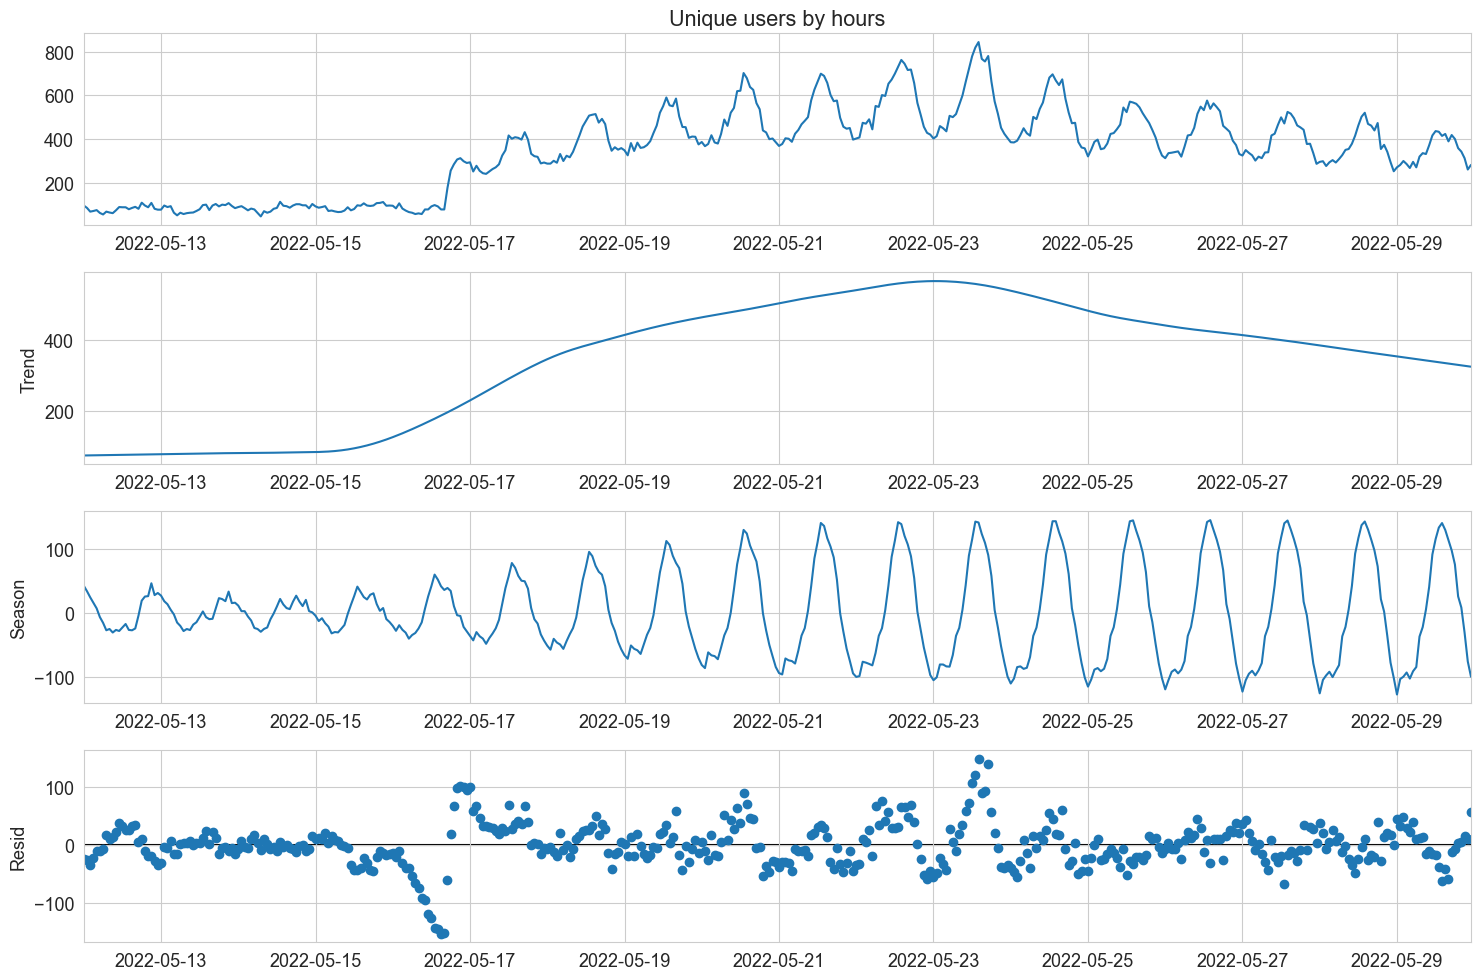

In [323]:
from statsmodels.tsa.seasonal import STL
inception = unique_users_by_hours.event_date.iloc[0]
raw = list(unique_users_by_hours['Unique users'])
tsa_data = pd.Series(raw, index=pd.date_range(inception, periods=len(raw), freq='h'), name = 'Unique users by hours')
tsa_data = tsa_data.interpolate(method='spline', order=3)

stl = STL(tsa_data, period=24, trend=99, seasonal=19)
plt.rc('figure',figsize=(15,10))
plt.rc('font',size=13)
sns.set_style('whitegrid')

stl.fit().plot()
plt.show()

# Save data to table
stl_res = stl.fit()
comps_all = pd.concat([stl_res.trend, stl_res.seasonal, stl_res.resid], 1)
# comps_all.head()

In [324]:
# add original, rearrange columns
comps_all['original'] = tsa_data
comps_all = comps_all[comps_all.columns[[3, 0, 1, 2]]]
comps_all[:5]

original      trend     season      resid
2022-05-12 00:00:00        95  76.273703  42.770976 -24.044680
2022-05-12 01:00:00        84  76.425770  34.107217 -26.532986
2022-05-12 02:00:00        67  76.576587  24.528513 -34.105100
2022-05-12 03:00:00        70  76.726263  15.700519 -22.426782
2022-05-12 04:00:00        74  76.874975   7.153255 -10.028229

In [325]:
def plot_stl_together(df):
    i = 0
    plt.subplots(figsize=(10, 7))
    for col in df.columns:
        lw_list = [1, 3, 1, 0.5]
        ax = plt.plot(df.index, df[col], lw=lw_list[i])
        i = i+1
        
    plt.ylabel('Unique users')
    plt.xlabel('Time')
    plt.title('Unique users by hour')
    # x ticks
    x_ticks = [df.index[x] for x in range(len(df)) if x%24 == 0]
    # labels
    lbl_list = [df.index[x].date() for x in range(len(df.index)) if x%24 == 0]
    plt.xticks(ticks = x_ticks, rotation=90, labels=lbl_list)
    plt.xlim(min(df.index), max(df.index)) # option only
    plt.grid()
    plt.legend(df.columns)
    plt.show()

Now we can visualise the trend with our original data

### Plot the trend and the season <a class="anchor" id="trend"></a>

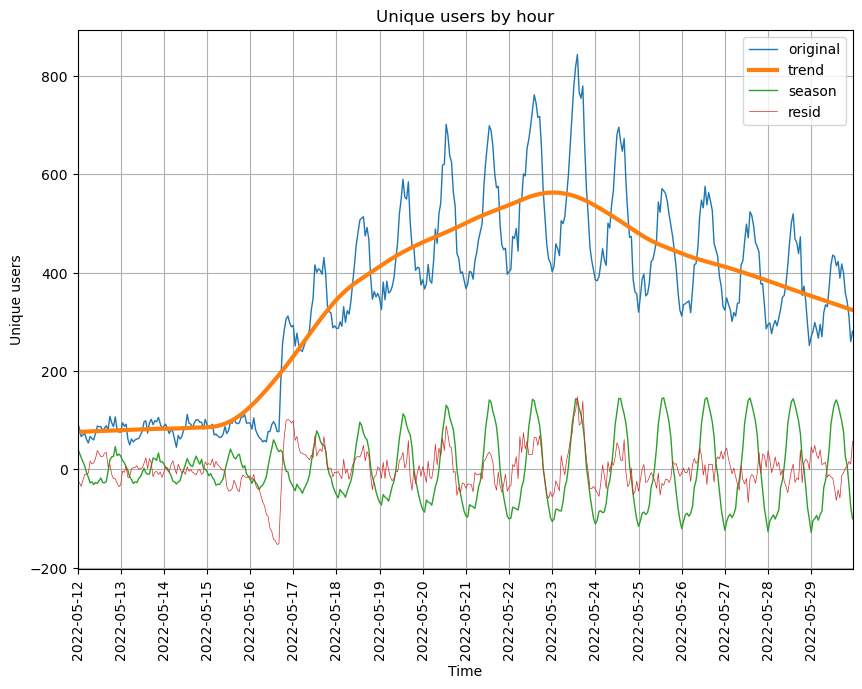

In [326]:
plt.rcParams.update(plt.rcParamsDefault) # reset settings before STL
plot_stl_together(comps_all)

We have the trend, started at less than 100 unique users in hour to almost 600 unique users in hour. After 23.05 trend is going down, it's planned scenario. <br>Users located all over the world, thats the reason that even minimums on original data are pretty high. Anyway there are peaks for core auditory.

## Part 1.2 Level time <a class="anchor" id="level_time"></a>
Here we want to exlore which level is maximal for which number of users and how long it take to get there

In [327]:
# globe_normal.head()

In [328]:
# add get start time column
globe_normal['start_time'] = None

# level 1 will be our mark of start_date
globe_normal.loc[globe_normal['level_number'] == 1, 'start_time'] = globe_normal['event_datetime']

# get sart_time per user by appmetrica_device_id
user_start_time = globe_normal[['appmetrica_device_id', 'start_time']].dropna()
user_start_time = user_start_time.set_index('appmetrica_device_id').to_dict()['start_time']

# spread sart_time to all events
globe_normal['start_time'] = globe_normal['appmetrica_device_id'].map(user_start_time)
# globe_normal['start_time']
# user_start_time
# add "user_time_in_app" column for all events ("time" in seconds)
globe_normal['event_datetime'] = pd.to_datetime(globe_normal['event_datetime'])
globe_normal['start_time'] = pd.to_datetime(globe_normal['start_time'])
globe_normal['user_time_in_app'] = globe_normal['event_datetime'] - globe_normal['start_time']
globe_normal['user_time_in_app'] = globe_normal['user_time_in_app'].dt.total_seconds() / 60 / 60 # in hours, global, not online time

### Plot amount of users by max level <a class="anchor" id="level_max"></a>

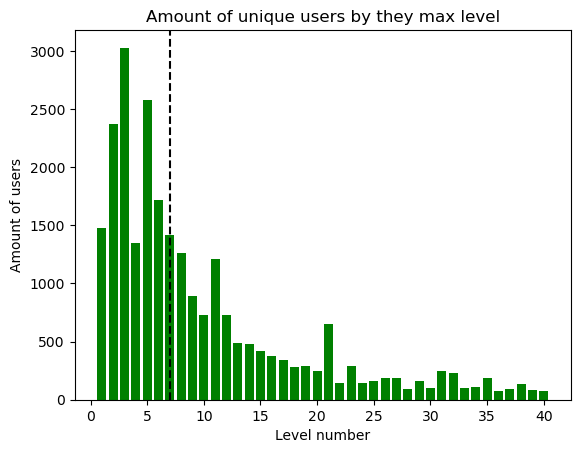

Median level is 7


In [329]:
# plot users by levels
users_max_level = globe_normal.groupby('appmetrica_device_id')['level_number'].max()
users_max_level_dist = pd.DataFrame(users_max_level).groupby('level_number')['level_number'].count()
limit = 40
median_level = int(users_max_level.median())
plt.bar(users_max_level_dist.index[:limit], users_max_level_dist.values[:limit], color='g')
plt.title('Amount of unique users by they max level')
plt.xlabel('Level number')
plt.ylabel('Amount of users')
plt.axvline(median_level, color='k', linestyle='--')
plt.show()
print('Median level is', median_level)

A lot of users stop there for some reason: 3, 5, 11, 21<br> Maybe those levels are harder or have some bugs

In [330]:
# prepare the data for visualisation
user_time_by_levels = globe_normal.groupby(['appmetrica_device_id', 'level_number'], as_index=False)['user_time_in_app'].min()
user_time_by_levels['level_number'] = user_time_by_levels['level_number'].astype(int)
user_time_by_levels = user_time_by_levels.sort_values('level_number')
user_time_by_levels.dropna(inplace=True)#.head()
user_time_by_levels = user_time_by_levels[user_time_by_levels.user_time_in_app >= 0]
# user_time_by_levels

In [331]:
# check the number of users
user_time_by_levels.appmetrica_device_id.nunique()

24855

### Visualisations user level by time<a class="anchor" id="level_vis"></a>

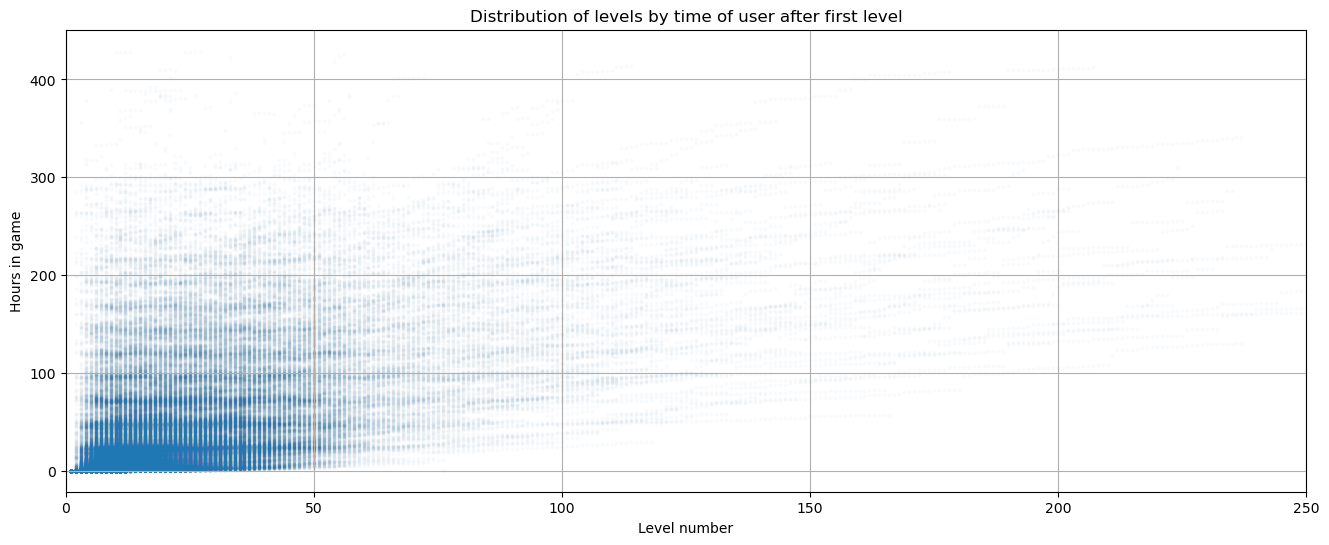

In [332]:
plt.subplots(figsize=(16, 6))
plt.scatter(user_time_by_levels.level_number, user_time_by_levels.user_time_in_app, alpha=.02, s=3)
plt.xlim(0, 250)
# plt.ylim(0, 150)
plt.title('Distribution of levels by time of user after first level')
plt.xlabel('Level number')
plt.ylabel('Hours in game')
plt.grid()
plt.show()

We clearly observe the core - most users are spending small number of days and not crossing the line of 50 level<br>
Let's look at the same data from another perspective - splitted on individual users

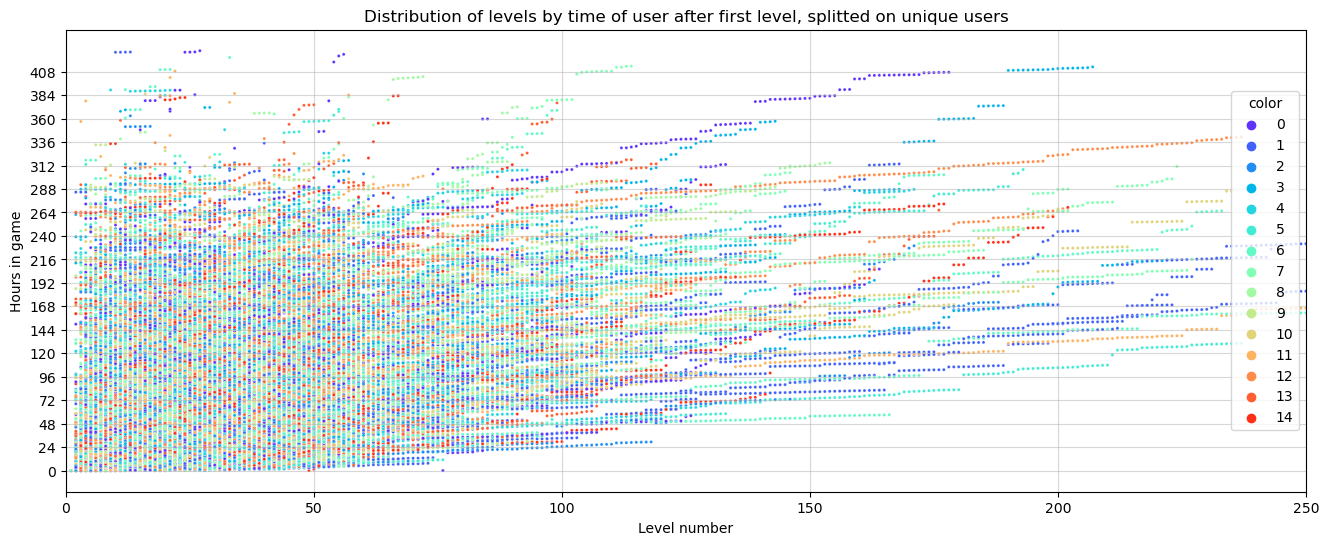

In [333]:
plt.subplots(figsize=(16, 6))
spectr_divider = 15

ax = sns.scatterplot(data=user_time_by_levels, 
                x='level_number', 
                y='user_time_in_app', 
                alpha=1, 
                s=5, 
                hue=user_time_by_levels.appmetrica_device_id % spectr_divider,
                palette=sns.color_palette('rainbow', spectr_divider))

major_ticks = np.arange(0, 409, 24)
ax.set_yticks(major_ticks)
ax.grid(which='both')
ax.grid(which='major', alpha=0.5)

plt.title('Distribution of levels by time of user after first level, splitted on unique users')
plt.xlabel('Level number')
plt.ylabel('Hours in game')
plt.xlim(0, 250)
plt.legend(title='color', loc=7)
plt.grid()
plt.show()

Here we have a colorfull mass, generally it's like the one we observed in previous plot, but here we have another story - we can to distinguish unique users. Every one of them make a "line", with some angle and charachter of dashing. Also could be interesting to look at some subgroups an compare them.

# Part 2. Global retention for all users <a class="anchor" id="global_ret"></a>
There are different ways to calculate and visualize retention - by chart and heat map. Will use both of them.

### Global retention <a class="anchor" id="global_ret_calc"></a>
Retention for all users:

In [334]:
# now we can group by user "age" user and check the number of unique users in app
users_by_days = globe_normal.groupby(['user_age_in_app'], as_index=False)['appmetrica_device_id'].nunique()
users_by_days.rename(columns={'appmetrica_device_id':'Unique users'}, inplace=True)
users_by_days[13:-10]

user_age_in_app  Unique users
13             -3.0            72
14             -2.0           112
15             -1.0           208
16              0.0         25081
17              1.0          8250
18              2.0          5415
19              3.0          4125
20              4.0          3257
21              5.0          2667
22              6.0          2236
23              7.0          1827
24              8.0          1393

Filter users with "negative age in app":

In [335]:
# some users installed an app days before they started level 1 (our mark of start_date) so for now we will get rid of them
users_by_days = users_by_days[users_by_days.user_age_in_app >= 0]
users_by_days.user_age_in_app = users_by_days.user_age_in_app.astype(int)

### Plot global retention chart<a class="anchor" id="global_ret_plot"></a>

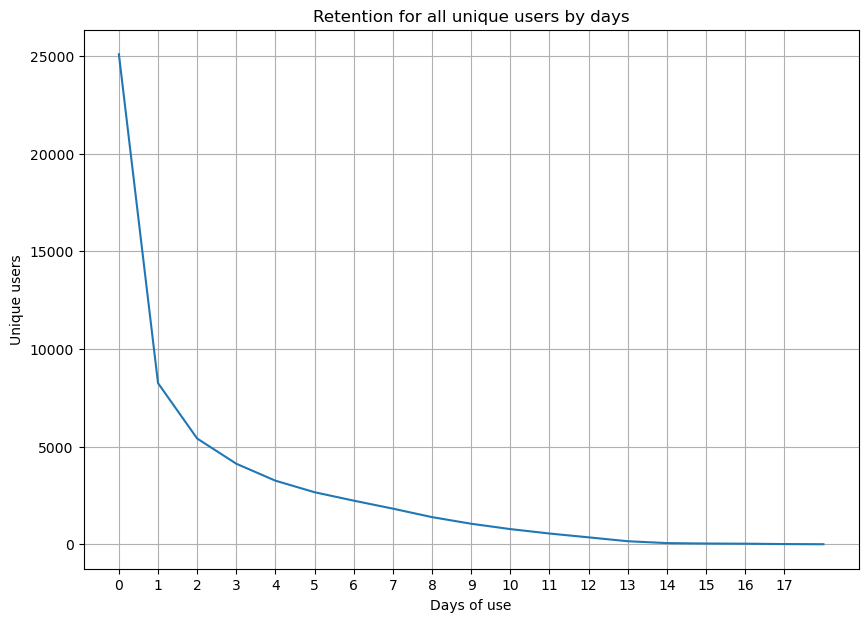

In [336]:
# plot global retention
plt.rcParams.update(plt.rcParamsDefault) # reset settings after STL
plt.subplots(figsize=(10, 7))
ax = sns.lineplot(data=users_by_days, x='user_age_in_app', y='Unique users')
plt.title('Retention for all unique users by days')
plt.xlabel('Days of use')
plt.ylabel('Unique users')
major_ticks = np.arange(min(users_by_days['user_age_in_app']), max(users_by_days['user_age_in_app']))
plt.grid()
ax.set_xticks(major_ticks)
plt.show()

In [337]:
# get shortlist for retention
users_by_first_days = users_by_days[:5]
users_by_first_days

user_age_in_app  Unique users
16                0         25081
17                1          8250
18                2          5415
19                3          4125
20                4          3257

Here we observe pretty standart curve charachter for retention, it's for all users for now, so it's in absolute values. Let's plot something little bit more interesting - a heat map of retention, and now it will be normalized to compare cohorts from different dates

### Global retention heat map <a class="anchor" id="global_ret_heat_map"></a>

#### Construct the table by start day <a class="anchor" id="global_ret_table"></a>

In [338]:
# group ALL users by dates
ret_all = globe_normal.groupby(['start_date', 'event_date'], as_index=False)['appmetrica_device_id'].nunique()
ret_all.rename(columns={'appmetrica_device_id':'Unique users'}, inplace=True)
ret_all.head() #

start_date event_date  Unique users
0 2022-05-12 2022-05-12           114
1 2022-05-12 2022-05-13            45
2 2022-05-12 2022-05-14            28
3 2022-05-12 2022-05-15            25
4 2022-05-12 2022-05-16            18

In [339]:
ret_all_pvt = ret_all.pivot(index='start_date', columns='event_date', values='Unique users')
ret_all_pvt = ret_all_pvt.fillna(0).astype(int)
ret_all_pvt

event_date  2022-05-12  2022-05-13  2022-05-14  2022-05-15  2022-05-16  \
start_date                                                               
2022-05-12         114          45          28          25          18   
2022-05-13           3         100          39          33          22   
2022-05-14           4           5         127          47          35   
2022-05-15           1           1           1         167          50   
2022-05-16           1           1           0           1         999   
2022-05-17           5           2           1           2          13   
2022-05-18           1           2           1           2           9   
2022-05-19           4           1           0           0           4   
2022-05-20           2           1           2           3           6   
2022-05-21           3           0           0           1           5   
2022-05-22           1           1           1           0           2   
2022-05-23           1           1           1           1           0   
2022-05-24           0           3           2           2           1   
2022-05-25           2           1           1           1           2   
2022-05-26           0           1           0           0           0   
2022-05-27           1           1           1           1           1   
2022-05-28           1           2           1           1           0   
2022-05-29           0           0           0           1           2   
2022-05-30           0           0           0           0           0   

event_date  2022-05-17  2022-05-18  2022-05-19  2022-05-20  2022-05-21  \
start_date                                                               
2022-05-12          18          11          10          11          12   
2022-05-13          20          18          21          13          19   
2022-05-14          28          22          21          16          20   
2022-05-15          37          25          23          19          19   
2022-05-16         390         245         158         131         113   
2022-05-17        2494         892         612         473         408   
2022-05-18          28        2411         915         616         504   
2022-05-19          17          22        2424         845         550   
2022-05-20           7          13          17        2497         849   
2022-05-21           7           7           8          11        2481   
2022-05-22           6           7           7           7          17   
2022-05-23           0           0           0           0           1   
2022-05-24           1           1           0           0           0   
2022-05-25           2           3           4           3           3   
2022-05-26           0           1           3           7           8   
2022-05-27           1           1           2           7          10   
2022-05-28           1           1           1           1           7   
2022-05-29           0           0           1           2           1   
2022-05-30           0           0           0           0           0   

event_date  2022-05-22  2022-05-23  2022-05-24  2022-05-25  2022-05-26  \
start_date                                                               
2022-05-12          11          11          10           8          10   
2022-05-13          17          15          13          16           9   
2022-05-14          19          17          13          17          12   
2022-05-15          20          14          17          20          12   
2022-05-16          98          89          88          83          68   
2022-05-17         344         315         282         275         247   
2022-05-18         418         352         317         290         251   
2022-05-19         466         387         334         293         265   
2022-05-20         610         478         400         329         284   
2022-05-21         880         602         460         369         308   
20

Table by day in app

In [340]:
# group ALL users by day in app
ret_all_by_day = globe_normal.groupby(['user_age_in_app', 'event_date'], as_index=False)['appmetrica_device_id'].nunique()
ret_all_by_day.rename(columns={'appmetrica_device_id':'Unique users'}, inplace=True)

In [341]:
ret_all_by_day_pvt = ret_all_by_day.pivot(index='event_date', columns='user_age_in_app', values='Unique users')
ret_all_by_day_pvt = ret_all_by_day_pvt.fillna(0).astype(int)
# ret_all_by_day_pvt

#### Plot the heat map - users by start day <a class="anchor" id="global_ret_hm_plot"></a>

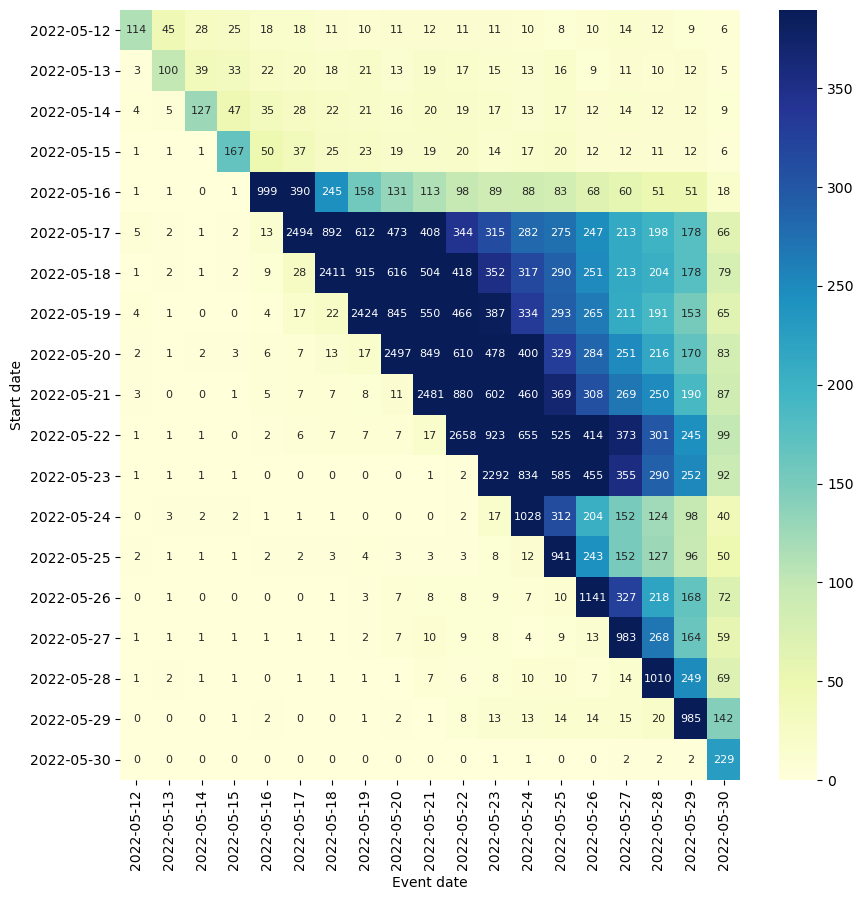

In [342]:
plt.subplots(figsize=(10, 10))
# absolute values
st_dev = ret_all_pvt.values.std()
ax = sns.heat map(data=ret_all_pvt, annot=True, fmt='d', vmin=0, vmax=st_dev, cmap='YlGnBu', annot_kws={"size":8})

#set readable labels
ticklabels = [ret_all_pvt.index[int(tick)].strftime('%Y-%m-%d') for tick in ax.get_xticks()]
ax.set_xticklabels(ticklabels)
ax.set_yticklabels(ticklabels)
plt.xlabel('Event date')
plt.ylabel('Start date')
plt.show()

Some days cohorts are different, we can check how it correspondents to campaigns or another actions influenced our traffic<br>For example the days with increased traffic standing out - 16-23.05<br>
<i>* last day is not completed<i>

<b>Normalized option</b>

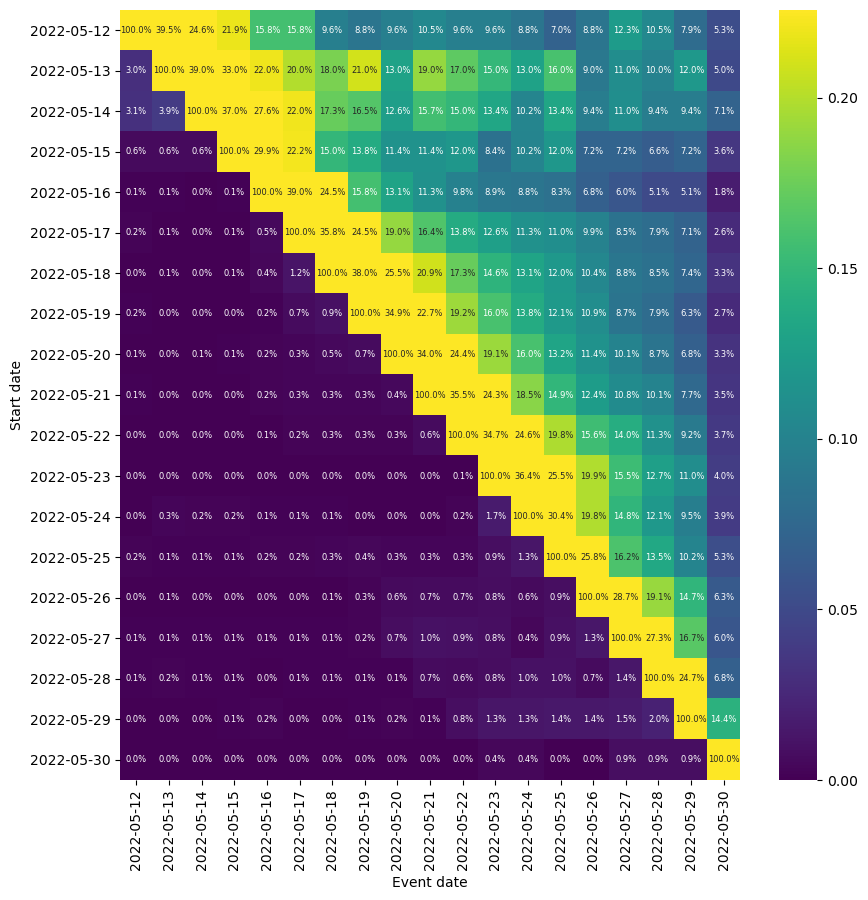

In [343]:
# normalised option
plt.subplots(figsize=(10, 10))
ret_all_pvt_norm = ret_all_pvt.div(ret_all_pvt.max(axis=1), axis=0)
st_dev = ret_all_pvt_norm.values.std()
ax = sns.heat map(data=ret_all_pvt_norm, annot=True, fmt='.1%', cmap='viridis', vmax=st_dev, annot_kws={"size":6})

#set readable labels
ticklabels = [ret_all_pvt.index[int(tick)].strftime('%Y-%m-%d') for tick in ax.get_xticks()]
ax.set_xticklabels(ticklabels)
ax.set_yticklabels(ticklabels)
plt.xlabel('Event date')
plt.ylabel('Start date')
plt.show()

Here we adjusted a colormap - maximum (yellow) is one standart deviation for now, to emphasize the differences by time.<br>

<i>* last day is not completed<i>


[More heat maps for different groups at part 5 - heat maps](#heat_maps)

In [344]:
# globe_normal.groupby('start_date')['appmetrica_device_id'].nunique()

# Part 3. Plot retention by A/B groups and categories<a class="anchor" id="to_functions"></a>

#### General steps are:
* get prepared data
* get subgroup of interest 
* get retention for this subgroup
* plot some groups together to compare

## A/B groups retentions <a class="anchor" id="ab"></a>

#### Functions to calculate and plot retentions by groups <a class="anchor" id="func"></a>

In [345]:
def get_retention(globe_normal):
    # group by user "age" in app (days)
    users_by_days = globe_normal.groupby(['user_age_in_app'], as_index=False)['appmetrica_device_id'].nunique()
    users_by_days.rename(columns={'appmetrica_device_id':'Unique users'}, inplace=True)
    # get rid of users installed days fefore level 1
    users_by_days = users_by_days[users_by_days.user_age_in_app >= 0]
    users_by_days.user_age_in_app = users_by_days.user_age_in_app.astype(int)
    return users_by_days

In [346]:
def plot_retention(list_of_groups, list_of_labels, title_suff, transp_coef=1, normal=False, title=True):
    plt.subplots(figsize=(14, 8))
    # absolute values
    if not normal:
        for group in list_of_groups:
            ax = sns.lineplot(data=group, x='user_age_in_app', y='Unique users')
            
        if title:
            list_of_labels_title = ', '.join(list_of_labels)
            plt.title(f'Retention for {list_of_labels_title} users by days{title_suff}')
        else:
            plt.title(f'Retention for users by days{title_suff}')
            
    # plot normalized
    else:
        # set maximum for transparency adjust
        maximum = 0
        for group in list_of_groups:
            try:
                if maximum < group['Unique users'].iloc[0]:
                    maximum = group['Unique users'].iloc[0]
            except IndexError:
                pass
            
        # plot in cycle    
        for group in list_of_groups:
            try:
                day_0_users_num = group['Unique users'].iloc[0]
            except IndexError:
                pass
            # get transparency normalized for every subgroup
            alpha = 1 / (maximum/transp_coef) * day_0_users_num

            if alpha > 1:
                alpha = 1
            group_norm = norm_table(group)
            ax = sns.lineplot(data=group_norm, x='user_age_in_app', y='Unique users', alpha=alpha)
        
        # upd title
        if title:
            list_of_labels_title = ', '.join(list_of_labels)
            plt.title(f'Retention for {list_of_labels_title} users by days{title_suff}, normalized')
        else:
            plt.title(f'Retention for users by days{title_suff}, normalized')
            
    plt.legend(list_of_labels[:25]) # ok, 25 will not explode the screen
    plt.xlabel('Days of use')
    plt.ylabel('Unique users')
    major_ticks = np.arange(0, len(max(list_of_groups, key=len)))
    plt.grid()
    ax.set_xticks(major_ticks)
    plt.show()

In [347]:
# test the function here
# plot_retention(ret_list_a[:25], phones_list[:25], title_suff=', by phones', transp_coef=3, normal=True, title=False)

#### Split A/B groups by version of app <a class="anchor" id="split"></a>
We will divide our users to different groups by different features, the first division is by app version, will use this function

In [350]:
# split to A and B groups
def split_ab(df):
    marker_column = 'app_version_name'
    A_marker = 22.4
    B_marker = 23.0
    df_a = df[df[marker_column] == A_marker]
    df_b = df[df[marker_column] == B_marker]
    return df_a, df_b

In [351]:
df_a, df_b = split_ab(globe_normal)

#### Get retention and check the balance<a class="anchor" id="get_ret"></a>

In [352]:
retention_all_a = get_retention(df_a)
retention_all_b = get_retention(df_b)

<b>Check the balance of two groups</b><br>
(divided by version) by comparing to day 0

In [353]:
retention_all_a[:3]

user_age_in_app  Unique users
16                0         12545
17                1          4146
18                2          2742

In [354]:
retention_all_b[:3]

user_age_in_app  Unique users
15                0         12537
16                1          4104
17                2          2673

Looks very similar, we can even continue without normalisation for now, but will implement it for future use

In [355]:
def norm_table(df):
    norm_df = df.copy(deep=True)
    day_0_users_num = norm_df['Unique users'].iloc[0]
    norm_df['Unique users'] = norm_df['Unique users'] / day_0_users_num
    return norm_df

In [356]:
# normalized table for example
norm_table(retention_all_b)[:3]

user_age_in_app  Unique users
15                0      1.000000
16                1      0.327351
17                2      0.213209

In [357]:
# plot_retention([retention_all_a], ['all'], title_suff='')

### Plot retentions by days for A/B groups <a class="anchor" id="ret_plot_ab"></a>

<b>Absolute users plot</b>

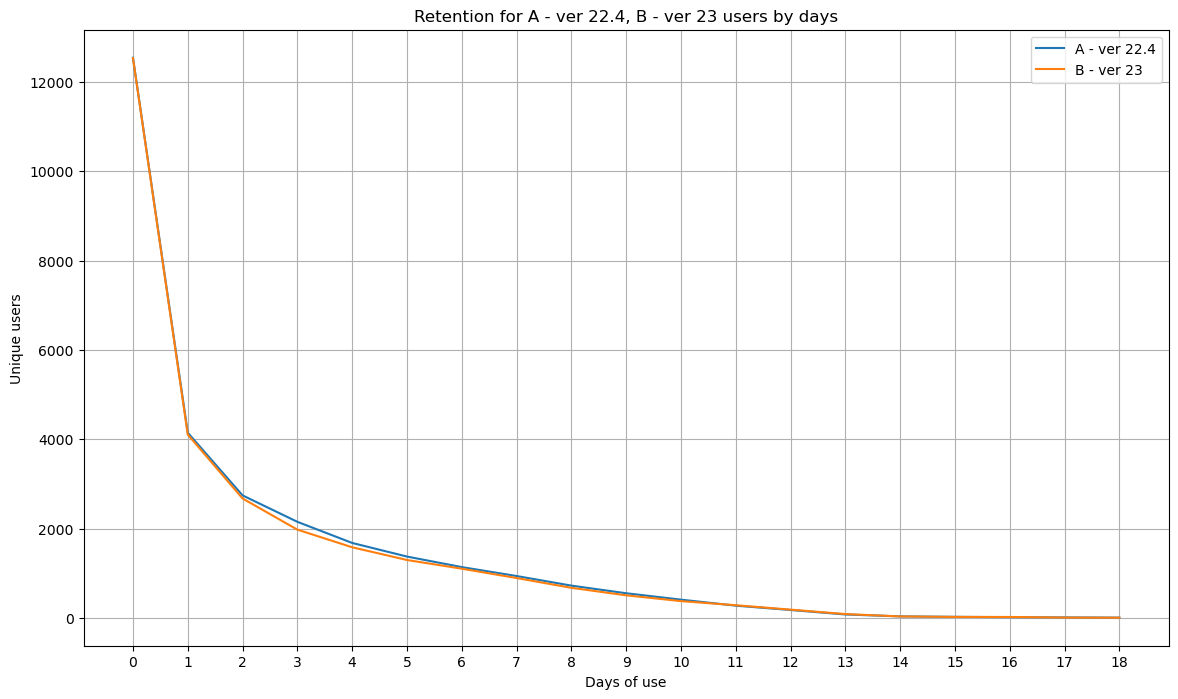

In [358]:
plot_retention([retention_all_a, retention_all_b], ['A - ver 22.4', 'B - ver 23'], title_suff='')

<b>Normalized users plot</b>

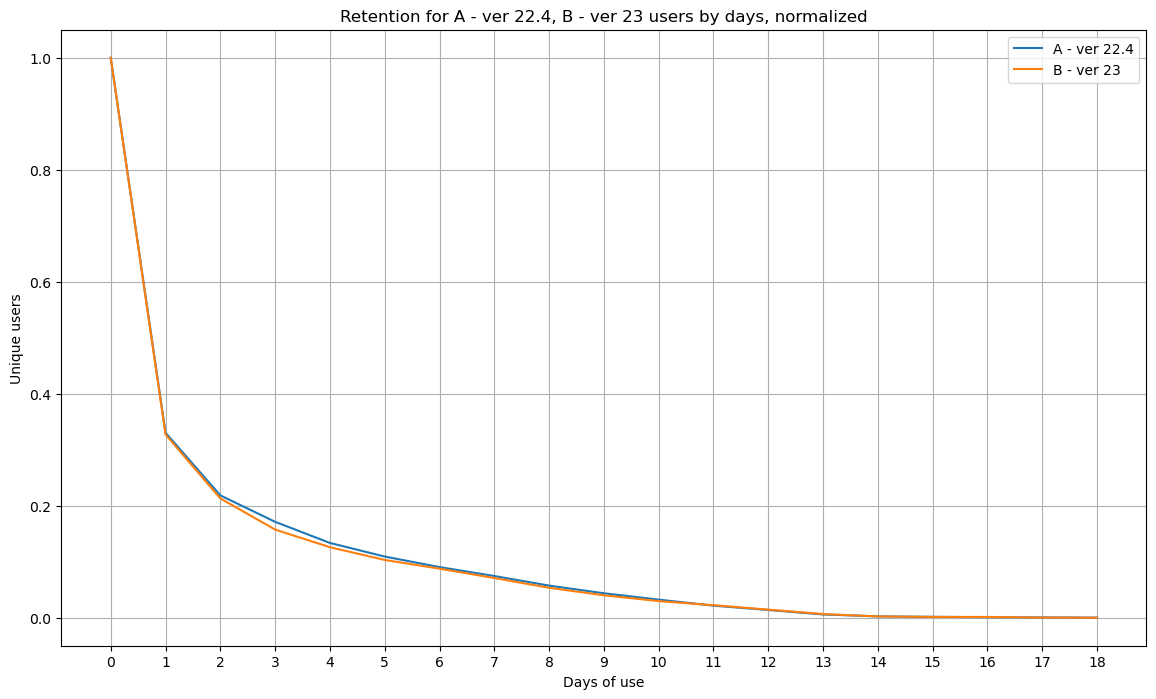

In [359]:
plot_retention([retention_all_a, retention_all_b], ['A - ver 22.4', 'B - ver 23'], normal=True, title_suff='')

Two versions look similar, will check different categories deeper, dividing by country or device brand

## Divide users by countries <a class="anchor" id="div_country"></a>
We will check if trere are some differences within one country. <br> For our function we will construct dictionaries for every country

In [361]:
# get list by category (counties or phones)
def get_list_by_category(globe_normal, category):
    category_list = list(globe_normal.groupby(by=category)['appmetrica_device_id'].nunique().sort_values(ascending=False).index)
    return category_list

In [362]:
# countries_events = globe_normal.country_iso_code.value_counts()
# countries_events

In [363]:
# Unique users by country
countries_users = globe_normal.groupby(by='country_iso_code')['appmetrica_device_id'].nunique().sort_values(ascending=False)
# countries_users

In [364]:
countries_list = get_list_by_category(globe_normal, 'country_iso_code')
print('Total number of countries is:', len(countries_list))
countries_list[:12]

Total number of countries is: 135


['PK', 'US', 'BR', 'IT', 'EG', 'AR', 'TR', 'ES', 'IN', 'DE', 'MX', 'ID']

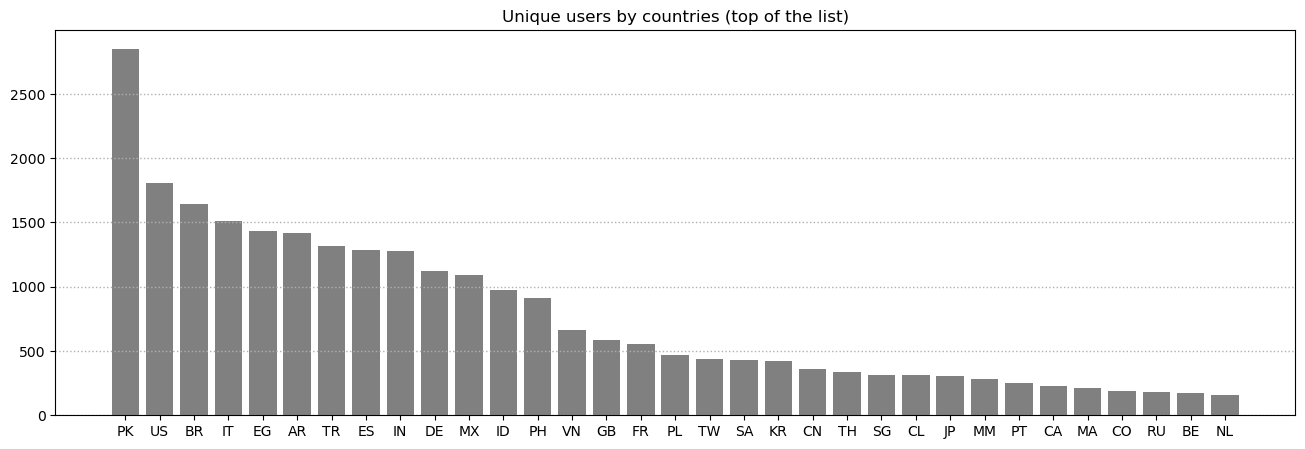

In [365]:
# plot countries UNIQUE USERS | 25% TOP
plt.subplots(figsize=(16, 5))
half = int(len(countries_users) / 2)
quart = int(half / 2)
# sns.barplot(countries_list.index, countries_list)
plt.bar(countries_users[:quart].index, countries_users[:quart], color='gray')
plt.title('Unique users by countries (top of the list)')
plt.grid(axis='y', ls=':', lw=1)

plt.show()

### Get dictionary for every group in in some category <a class="anchor" id="to_dict"></a>

In [369]:
# get data dictionary by category (country/phone)
def groups_by_category(globe_normal, category):
    result_dict = {}
    ret_list_a = []
    ret_list_b = []
    category_list = get_list_by_category(globe_normal, category)
    for element in category_list: 
        # filter for current type(country or phone)
        df_element = globe_normal[globe_normal[category] == element]

        # filter by app_version_name
        df_a, df_b = split_ab(df_element)

        # get retention
        users_by_days_a = get_retention(df_a)
        users_by_days_b = get_retention(df_b)

        # collect retentions to lists
        ret_list_a.append(users_by_days_a)
        ret_list_b.append(users_by_days_b)


    # construct dictionaries
    result_dict_a = dict(zip(category_list, ret_list_a))
    result_dict_b = dict(zip(category_list, ret_list_b))
    return result_dict_a, result_dict_b, ret_list_a, ret_list_b

In [370]:
result_dict_a, result_dict_b, ret_list_a, ret_list_b = groups_by_category(globe_normal, 'country_iso_code')

In [372]:
# test data we get
result_dict_b['US']

user_age_in_app  Unique users
6                 0           602
7                 1           220
8                 2           151
9                 3           114
10                4            87
11                5            73
12                6            63
13                7            59
14                8            43
15                9            36
16               10            32
17               11            30
18               12            22
19               13            15
20               14            12
21               15             8
22               16            11
23               17             2
24               18             2

### Plot unnormalized data to visually check <a class="anchor" id="ret_plot_abs"></a>

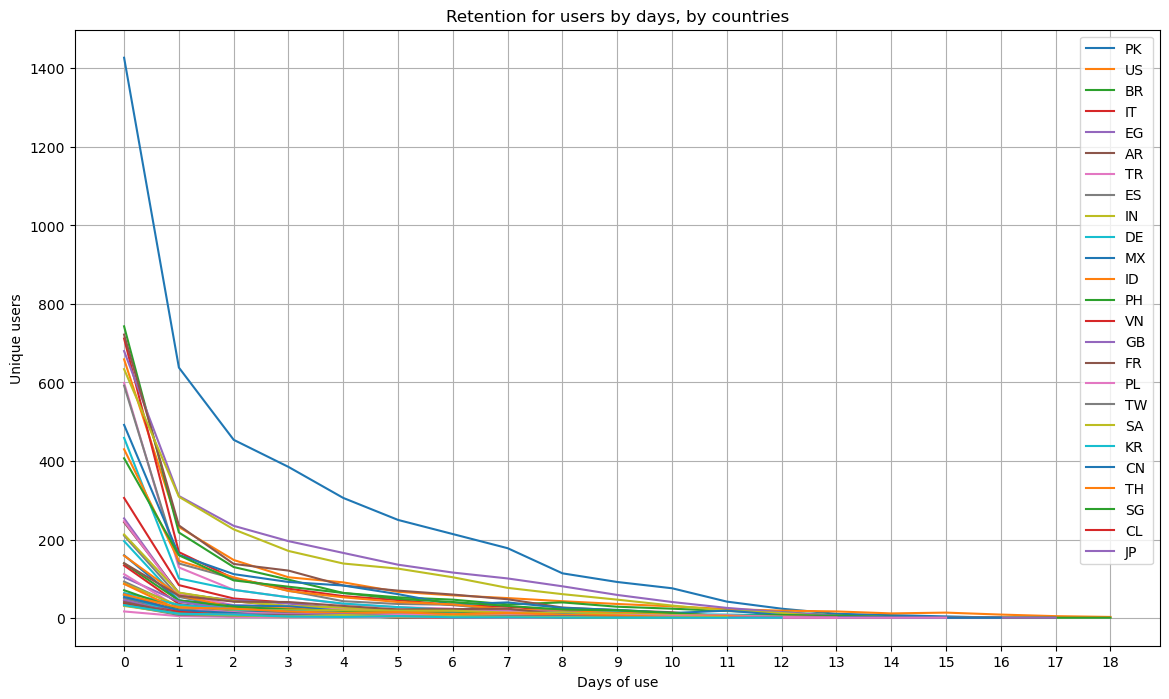

In [373]:
# plot UNNORMALIZED retentions for group A (to visually check data)
plot_retention(ret_list_a[:50], countries_list[:50], title_suff=', by countries', title=False)

Unnormalized plot give us good general picture, but to compare we have to normalize it

### Plot normalized data to compare <a class="anchor" id="ret_plot_norm"></a>

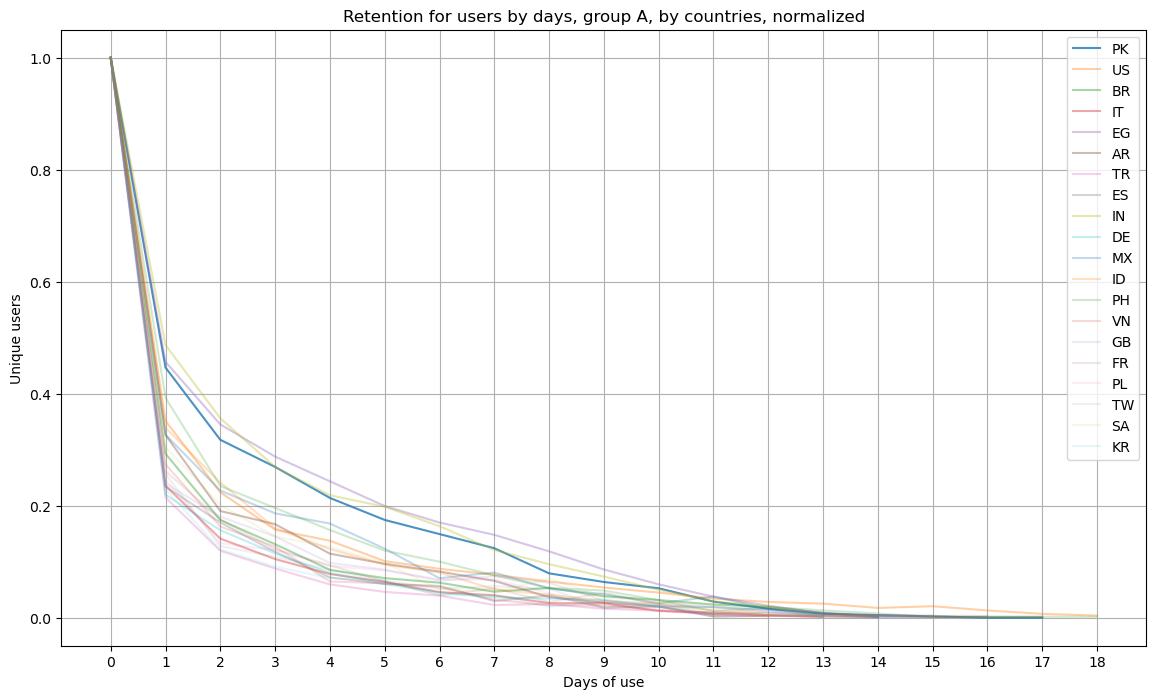

In [374]:
# plot NORMALIZED A
plot_retention(ret_list_a[:20], countries_list[:20], title_suff=', group A, by countries', transp_coef=.8, normal=True, title=False)

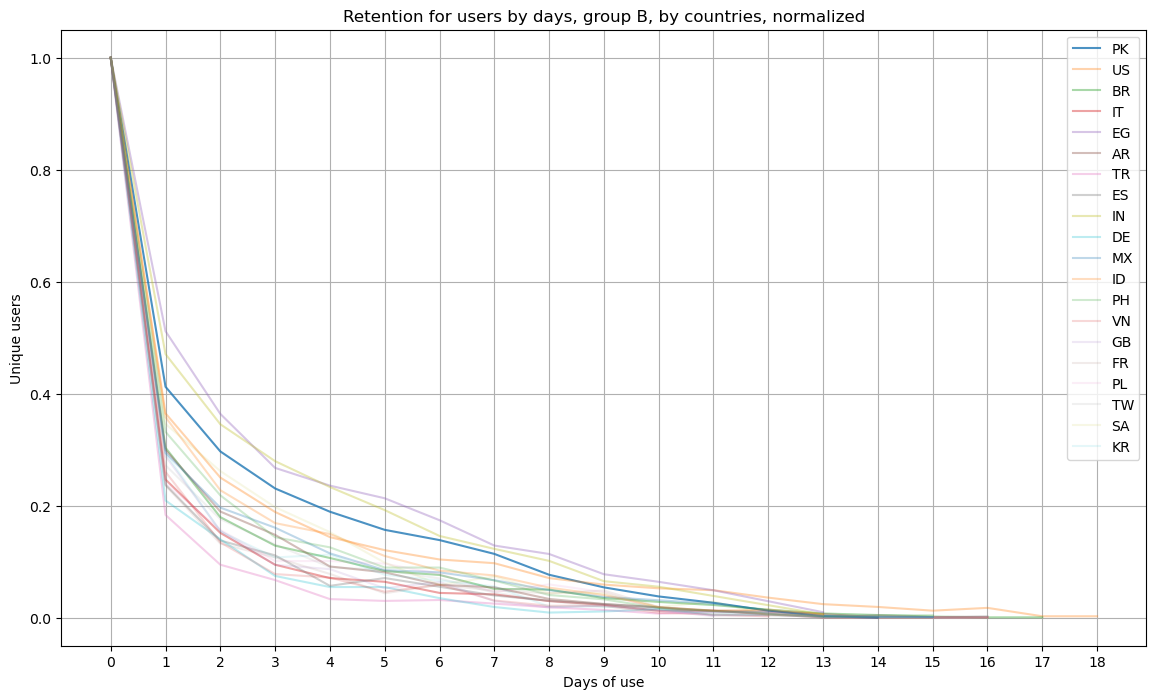

In [375]:
# plot NORMALIZED B
plot_retention(ret_list_b[:20], countries_list[:20], title_suff=', group B, by countries', transp_coef=.8, normal=True, title=False)

Normalized data already give us some trends. Plotting 20 first countries we can see where many of them are on the chart, which are on the top and the opposite.
<br>Another dimention added here is transparency by total number of users

### Compare A/B groups within one country <a class="anchor" id="compare_in_cat"></a>
Plot for some country by key (like `US` or `PK`)

In [376]:
# plot retentions for group A
def plot_from_dict_category(key, normal):
    A = result_dict_a[key]
    B = result_dict_b[key]
    plot_retention([A, B], ['A', 'B'], title_suff=', for '+str(key), normal=normal, title=True)

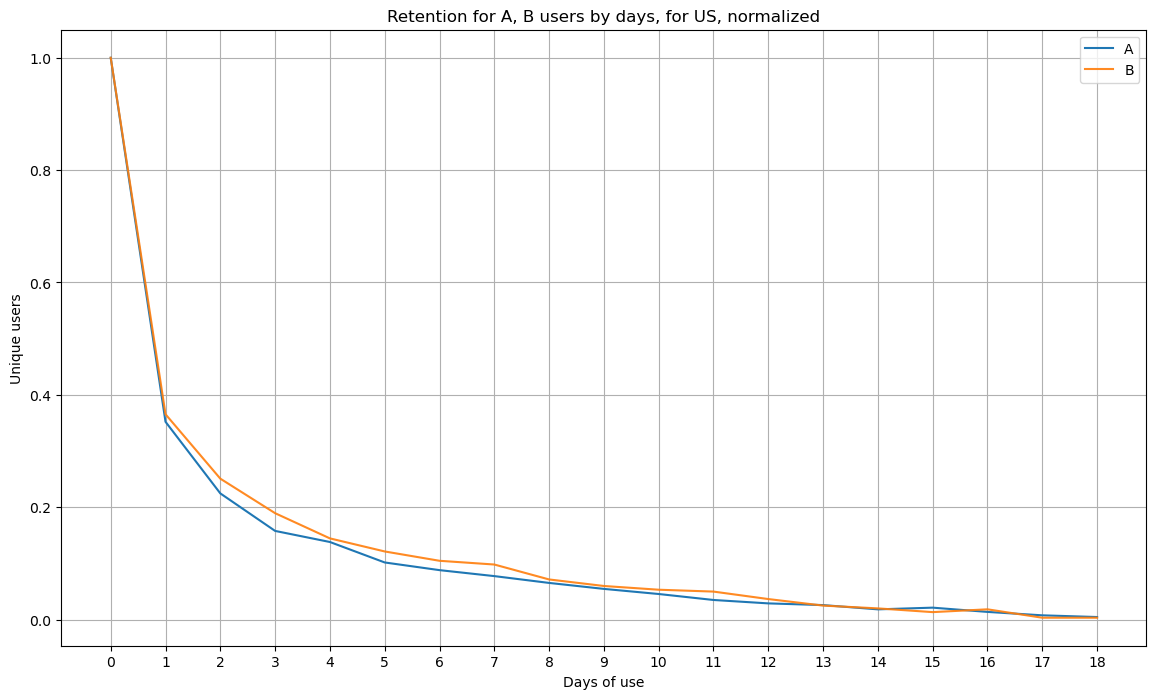

In [377]:
key = 'US'
plot_from_dict_category(key, normal=True) # normal for normalize

## Group Exception vs Others <a class="anchor" id="ex_vs_others"></a>
Another approach is to compare the one group vs all other groups. Will call it `Exception` vs `Others`<br>For example users in US vs all users it other counries or users of Samsung vs other brands. We know those are significant groups and we can expect some differences there

In [378]:
# print fisrt value to check
def print_group_first_value(list_of_groups):
    for group in list_of_groups:
        print(group['Unique users'].iloc[0])

The function to get 4 groups - divided by Exception/Others and by A/B:

In [379]:
# function to get all in category, except one vs exeption (for All/USA and All/Samsung compare for example)
def groups_all_and_exception(df, column, exception):
    
    # All except one
    # filter all without exception
    df_all_except_one = df[df[column] != exception]
    # filter by app_version_name
    df_except_one_a, df_except_one_b = split_ab(df_all_except_one)
    # get retention
    ret_by_days_all_ex_one_a = get_retention(df_except_one_a)
    ret_by_days_all_ex_one_b = get_retention(df_except_one_b)
    
    # Exception
    # filter exception only
    df_exception = df[df[column] == exception]
    # filter by app_version_name
    df_exception_a, df_exception_b = split_ab(df_exception)
    # get retention
    ret_by_days_one_a = get_retention(df_exception_a)
    ret_by_days_one_b = get_retention(df_exception_b)
    
    return ret_by_days_all_ex_one_a, ret_by_days_all_ex_one_b, ret_by_days_one_a, ret_by_days_one_b

In [380]:
ret_by_days_all_ex_one_a, ret_by_days_all_ex_one_b, ret_by_days_one_a, ret_by_days_one_b = groups_all_and_exception(globe_normal, 'country_iso_code', 'US')

In [381]:
# users_by_days_a

In [382]:
# users_by_days_b

In [383]:
# rename in separate cell to keep it simple
A_us = ret_by_days_one_a
B_us = ret_by_days_one_b
A_non_us = ret_by_days_all_ex_one_a
B_non_us = ret_by_days_all_ex_one_b

### Plot retention for 4 groups <a class="anchor" id="plot_4_ret"></a>
A/B groups, US/exUS world

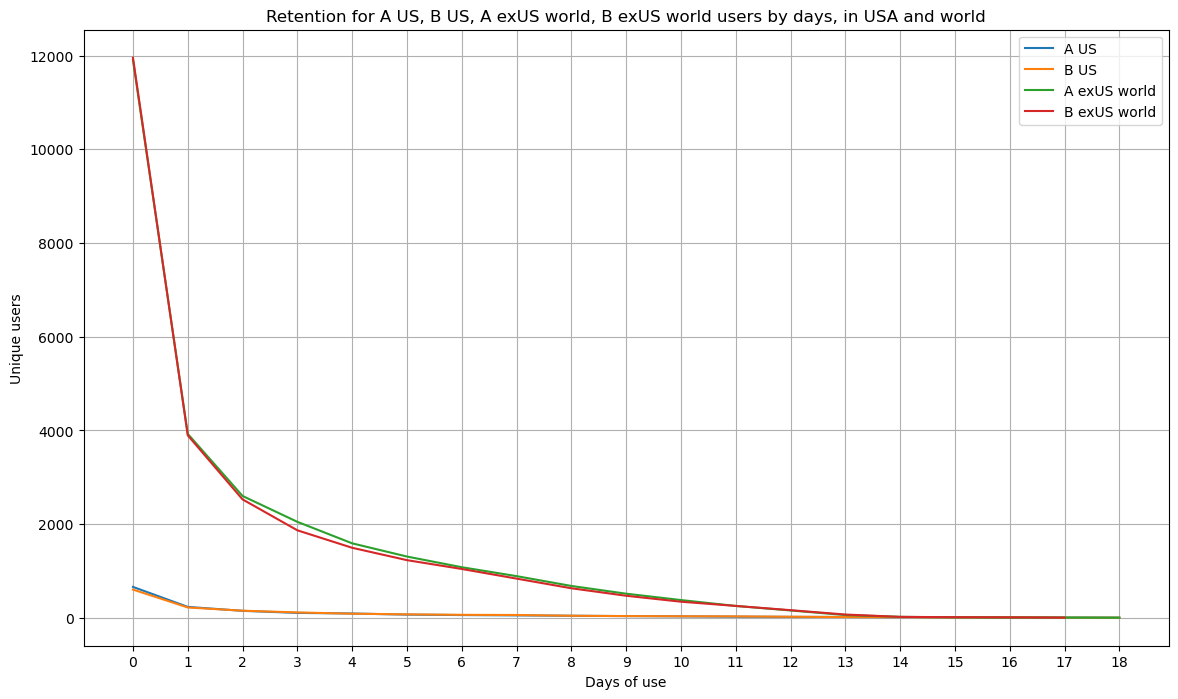

In [384]:
# Absolute values
plot_retention([A_us, B_us, A_non_us, B_non_us], ['A US', 'B US', 'A exUS world', 'B exUS world'], ', in USA and world', normal=False, title=True)
# plot_retention([A_us, B_us], ['A_us', 'B_us'], ', in USA', normal=True, title=True)

In absoluse values we get the proportion of users in US and in other countries

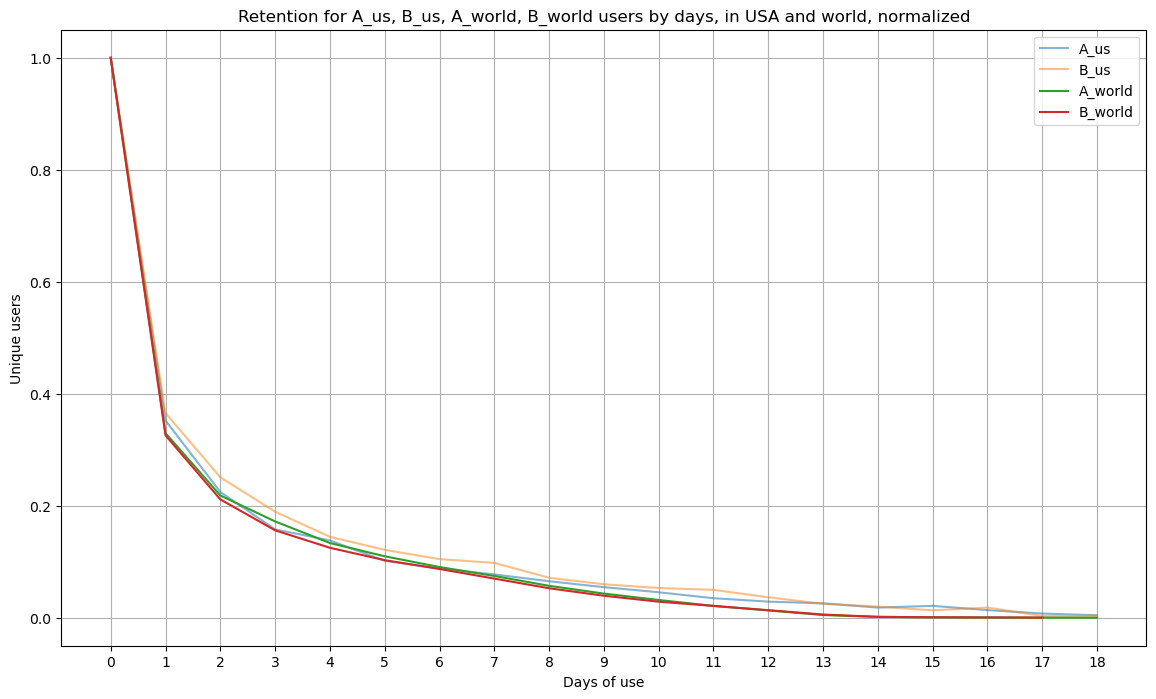

In [385]:
# Normalized values
plot_retention([A_us, B_us, A_non_us, B_non_us], ['A_us', 'B_us', 'A_world', 'B_world'], ', in USA and world', transp_coef=10, normal=True, title=True)

Normalised values can tell us that retention in US is slightly higher than in other countries. Maybe it's just regression to average, will test it further.

## Compare by device manufacturer <a class="anchor" id="by_device"></a>
Useres have different brand's devices, could it be a factor for retention? Will see

In [386]:
globe_normal.device_manufacturer.unique()[:15]

array(['Samsung', 'Motorola', 'Redmi', 'Zte', 'Vivo', 'Xiaomi', 'Realme',
       'POCO', 'Huawei', 'Oppo', 'Alcatel', 'Nokia', 'Zuum', 'Infinix',
       'OnePlus'], dtype=object)

In [387]:
globe_normal.device_manufacturer.nunique()

245

In [388]:
# globe_normal.device_manufacturer.value_counts() # events

In [389]:
# Unique users by devise
phone_users = globe_normal.groupby(by='device_manufacturer')['appmetrica_device_id'].nunique().sort_values(ascending=False)
phone_users

device_manufacturer
Samsung           10788
Oppo               2536
Huawei             2361
Redmi              2061
Motorola           1949
                  ...  
LT Electronics        1
LWS                   1
Laser                 1
Leagoo                1
stack                 1
Name: appmetrica_device_id, Length: 245, dtype: int64

In [390]:
phones_list = list(phone_users.index)

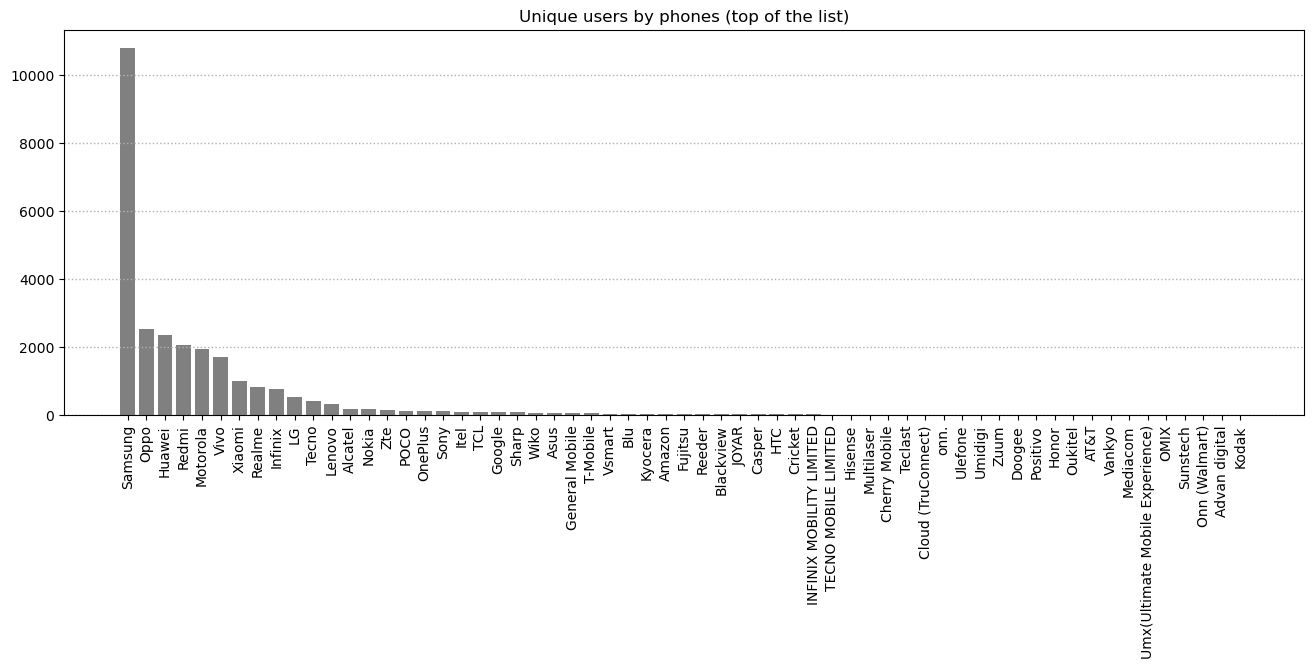

In [391]:
# plot phones UNIQUE USERS | 25% TOP
plt.subplots(figsize=(16, 5))
half = int(len(phone_users) / 2)
quart = int(half / 2)
plt.bar(phone_users[:quart].index, phone_users[:quart], color='gray')
plt.title('Unique users by phones (top of the list)')
plt.xticks(rotation=90)
plt.grid(axis='y', ls=':', lw=1)

plt.show()

Obviously the Samsung is prevailing here, will check it vs others so. The tail is very long, hence to get rid of small cohort's noise we will look at Samsung vs top 10 after it. It is more than 90% users anyway.

## Samsung vs top 10 after S. <a class="anchor" id="sam_to10"></a>

In [392]:
# set list frop top 10 after Samsung
top_other_phones_no_sm = list(phone_users[1:11].index)
top_other_phones_no_sm

['Oppo',
 'Huawei',
 'Redmi',
 'Motorola',
 'Vivo',
 'Xiaomi',
 'Realme',
 'Infinix',
 'LG',
 'Tecno']

Will filter Top 10 ater Samsung to this table:

In [393]:
top_after_sm = globe_normal[globe_normal.device_manufacturer.isin(top_other_phones_no_sm)]
can_show(top_after_sm.head(3))

level_number appmetrica_device_id      event_datetime device_manufacturer  \
7           9.0            000000000 2022-05-30 00:00:56            Motorola   
8          10.0            000000000 2022-05-30 00:03:31            Motorola   
9          15.0            000000000 2022-05-30 00:04:45               Redmi   

  country_iso_code  app_version_name event_date start_date  user_age_in_app  \
7               AR              22.4 2022-05-30 2022-05-29              1.0   
8               AR              22.4 2022-05-30 2022-05-29              1.0   
9               PT              23.0 2022-05-30 2022-05-26              4.0   

  hour          start_time  user_time_in_app  
7   00 2022-05-29 23:48:41          0.204167  
8   00 2022-05-29 23:48:41          0.247222  
9   00 2022-05-26 23:22:31         72.703889

Will filter Samsung only event to this table:

In [394]:
samsung_only = globe_normal[globe_normal.device_manufacturer == 'Samsung']
can_show(samsung_only.head(3))

level_number appmetrica_device_id      event_datetime device_manufacturer  \
0          36.0            000000000 2022-05-30 00:08:42             Samsung   
1          37.0            000000000 2022-05-30 00:18:13             Samsung   
2          37.0            000000000 2022-05-30 00:23:37             Samsung   

  country_iso_code  app_version_name event_date start_date  user_age_in_app  \
0               AR              23.0 2022-05-30 2022-05-29              1.0   
1               AR              23.0 2022-05-30 2022-05-29              1.0   
2               AR              23.0 2022-05-30 2022-05-29              1.0   

  hour          start_time  user_time_in_app  
0   00 2022-05-29 03:35:31         20.553056  
1   00 2022-05-29 03:35:31         20.711667  
2   00 2022-05-29 03:35:31         20.801667

In [395]:
# percent of top_after_sm unique users
top_after_sm_percent = top_after_sm.appmetrica_device_id.nunique() / globe_normal.appmetrica_device_id.nunique() * 100
# persent of samsung unique users
samsung_percent = samsung_only.appmetrica_device_id.nunique() / globe_normal.appmetrica_device_id.nunique() * 100
print(f'Samsung users:        {round(samsung_percent, 2)}%')
print(f'Top 10 after Samsung: {round(top_after_sm_percent, 2)}%')
print(f'Total percent is:     {round(top_after_sm_percent+samsung_percent, 2)}%')

Samsung users:        39.04%
Top 10 after Samsung: 51.18%
Total percent is:     90.22%


Will explore better those more than 90% of users

In [396]:
# get list with samsung to use same function as bebore
top_phones = list(phone_users[:11].index)
top_11 = globe_normal[globe_normal.device_manufacturer.isin(top_phones)]
top_11.shape

(496179, 12)

In [397]:
# get exception and others by function
A_not_samsung_10, B_not_samsung_10, A_samsung, B_samsung = \
groups_all_and_exception(top_11, 'device_manufacturer', 'Samsung')

In [398]:
# check after balance # have to be the same!
print_group_first_value([A_samsung, B_samsung, A_not_samsung_10, B_not_samsung_10])

4843
4807
6500
6587


### Plots Samsung vs 10 after S. <a class="anchor" id="sam_to10_plot"></a>

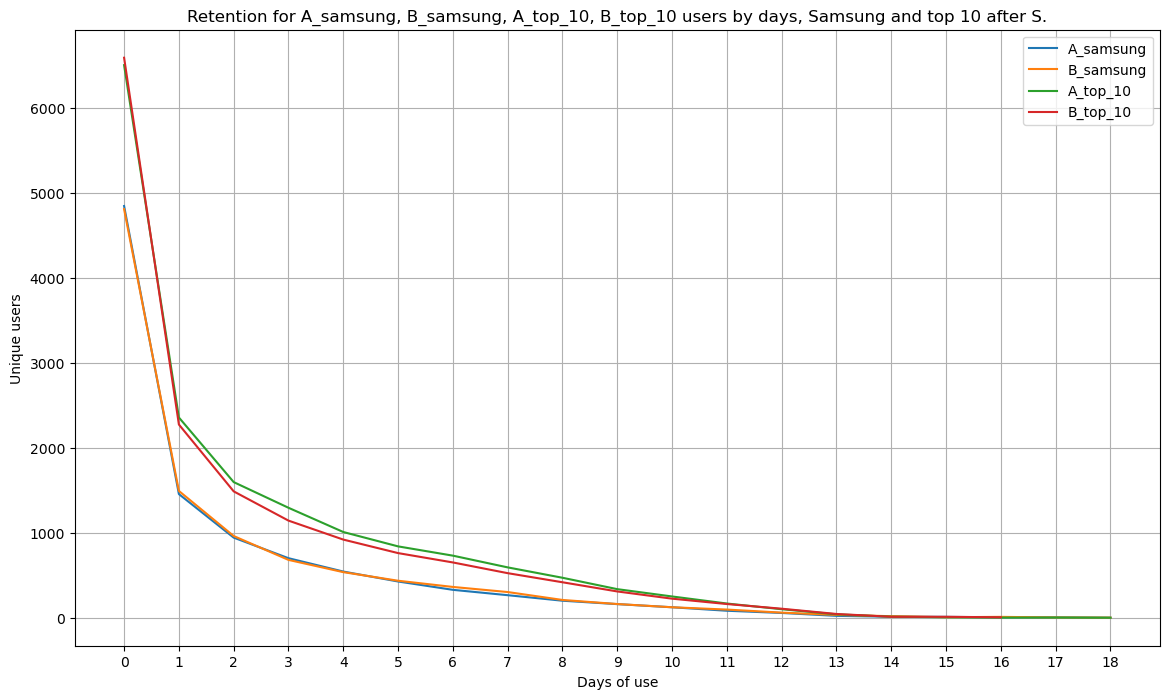

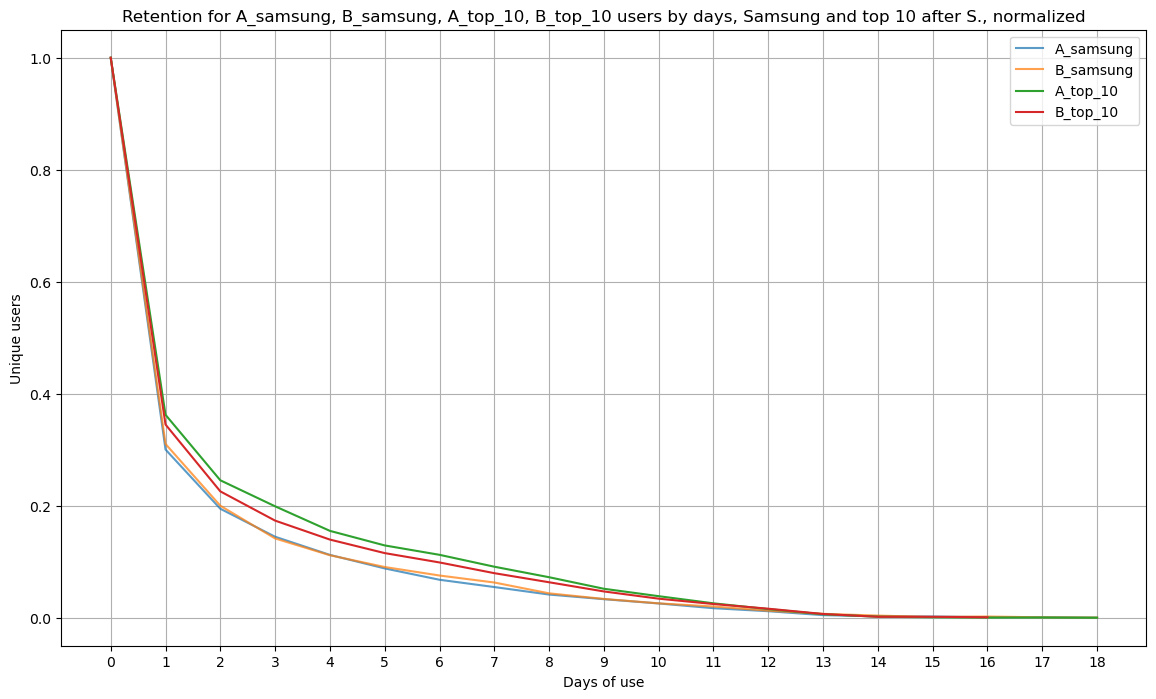

In [399]:
# absolute
plot_retention([A_samsung, B_samsung, A_not_samsung_10, B_not_samsung_10], ['A_samsung', 'B_samsung', 'A_top_10', 'B_top_10'], ', Samsung and top 10 after S.', normal=False, title=True)
# normalized
plot_retention([A_samsung, B_samsung, A_not_samsung_10, B_not_samsung_10], ['A_samsung', 'B_samsung', 'A_top_10', 'B_top_10'], ', Samsung and top 10 after S.', normal=True, title=True)
# plot_retention([A_us, B_us], ['A_us', 'B_us'], ', in USA', title=True)

We can see the graph of Samsung users retention loosing at days 1-10 (with enough users), will test it further

# Part 4. Separated cohorts, statistical tests <a class="anchor" id="sep_cohorts"></a>
In this part we will compare retention at some specific day in app (like on day 1 or day 2). Also we will apply statistical tests to this bunch of numbers.

## Retention for different groups, by days <a class="anchor" id="ret_days_all"></a>

### Updated retention functions, keepeng cohorts data <a class="anchor" id="upd_func"></a>

In [400]:
def get_retentions_by_days(df):
    # group users by dates
    ret = df.groupby(['user_age_in_app', 'event_date'], as_index=False)['appmetrica_device_id'].nunique()
    ret.rename(columns={'appmetrica_device_id':'Unique users'}, inplace=True)
    # get rid of users insalled app days before play level one
    # ret_all = ret_all[ret_all.start_date <= ret_all.event_date]
    ret_by_days = ret.pivot(index='user_age_in_app', columns='event_date', values='Unique users')
    ret_by_days = ret_by_days.fillna(0).astype(int)
    return ret_by_days

In [401]:
# test here
# get_retentions_by_days(globe_normal)

In [402]:
# get data dictionary by categoty (country, phone)
def groups_by_category_by_days(globe_normal, category):
    result_dict = {}
    ret_list_a = []
    ret_list_b = []
    category_list = get_list_by_category(globe_normal, category)
    for element in category_list: 
        # filter for current type(country or phone)
        df_element = globe_normal[globe_normal[category] == element]
        # filter by app_version_name
        df_a, df_b = split_ab(df_element)

        # get retention for DAY
        users_by_day_a = get_retentions_by_days(df_a)
        users_by_day_b = get_retentions_by_days(df_b)
        
        # collect retentions to lists
        ret_list_a.append(users_by_day_a)
        ret_list_b.append(users_by_day_b)


    # construct dictionaries
    result_dict_a = dict(zip(category_list, ret_list_a))
    result_dict_b = dict(zip(category_list, ret_list_b))
    return result_dict_a, result_dict_b, ret_list_a, ret_list_b

In [403]:
# function to get all in category, except one vs exception (for All/USA and All/Samsung compare for example)
def groups_all_and_exception_by_days(globe_normal, column, exception):

    # Exception
    # filter exception only
    df_exception = globe_normal[globe_normal[column] == exception]
    # filter by app_version_name
    df_exception_a, df_exception_b = split_ab(df_exception)
    # get retentions by DAYS
    ret_day_one_a = get_retentions_by_days(df_exception_a)
    ret_day_one_b = get_retentions_by_days(df_exception_b)    
    
    # Others
    # filter others without exception
    df_all_except_one = globe_normal[globe_normal[column] != exception]
    # filter by app_version_name
    df_except_one_a, df_except_one_b = split_ab(df_all_except_one)
    # get retentions by DAYS

    ret_day_all_ex_one_a = get_retentions_by_days(df_except_one_a)
    ret_day_all_ex_one_b = get_retentions_by_days(df_except_one_b)


    return ret_day_all_ex_one_a, ret_day_all_ex_one_b, ret_day_one_a, ret_day_one_b

In [404]:
def plot_retention_one_day(list_of_groups, list_of_labels, day, title_suff, title=True):
    plt.subplots(figsize=(8, 2))
    for group in list_of_groups:
        group_of_this_day_raw = group[group.index == day]
        group_of_this_day = pd.DataFrame({'event_date': group_of_this_day_raw.columns.tolist(), 'Unique users': group_of_this_day_raw.values[0]})
        ax = sns.lineplot(data=group_of_this_day[day:-1], x='event_date', y='Unique users')
        
    if title:
        list_of_labels_title = ', '.join(list_of_labels)
        plt.title(f'Retention for {list_of_labels_title} users from day {day}{title_suff}')
    else:
        plt.title(f'Retention for users from day {day}{title_suff}')

    plt.legend(list_of_labels[:25]) # ok, 25 will not explode the screen
    plt.xlabel('Start date')
    plt.xticks(rotation=45)
    plt.ylabel('Unique users')
    plt.ylim(0, None)
    plt.grid()
    plt.show()

In [405]:
# test function here
# plot_retention_one_day([A_exception_days, B_exception_days], ['A_us_day', 'B_us_day'], 1, f', in USA in day {day_num}', title=True)

### Filter by category, keeping the day <a class="anchor" id="cat_filter"></a>

In [406]:
result_dict_a, result_dict_b, ret_list_a, ret_list_b = groups_by_category_by_days(globe_normal, 'country_iso_code')

## Get Others vs Exception, keeping the day <a class="anchor" id="ot_exc_day"></a>

#### Test on US vs Others

In [407]:
A_others_days, B_others_days, A_exception_days, B_exception_days = groups_all_and_exception_by_days(globe_normal, 'country_iso_code', 'US')

In [408]:
# normalize the table by day 0
def normalize_table_by_day_0(table):
    return table.div(table[table.index == 0].values, axis=1)

#### Check the data
Now the table have a wide form, a value per every start_date and every event_date.

In [409]:
A_others_days[0:]

event_date       2022-05-12  2022-05-13  2022-05-14  2022-05-15  2022-05-16  \
user_age_in_app                                                               
0.0                      32          18          32          53         454   
1.0                       0           9           8          15          16   
2.0                       0           0           8           7          10   
3.0                       0           0           0           6           5   
4.0                       0           0           0           0           1   
5.0                       0           0           0           0           0   
6.0                       0           0           0           0           0   
7.0                       0           0           0           0           0   
8.0                       0           0           0           0           0   
9.0                       0           0           0           0           0   
10.0                      0           0           0           0           0   
11.0                      0           0           0           0           0   
12.0                      0           0           0           0           0   
13.0                      0           0           0           0           0   
14.0                      0           0           0           0           0   
15.0                      0           0           0           0           0   
16.0                      0           0           0           0           0   
17.0                      0           0           0           0           0   
18.0                      0           0           0           0           0   

event_date       2022-05-17  2022-05-18  2022-05-19  2022-05-20  2022-05-21  \
user_age_in_app                                                               
0.0                    1231        1159        1184        1162        1196   
1.0                     171         440         439         414         404   
2.0                      14         111         302         308         272   
3.0                       8          11          74         248         263   
4.0                       1           4          13          62         215   
5.0                       4           2           6          11          59   
6.0                       0           2           3           4           8   
7.0                       0           0           2           2           7   
8.0                       0           0           0           2           2   
9.0                       0           0           0           0           1   
10.0                      0           0           0           0           0   
11.0                      0           0           0           0           0   
12.0                      0           0           0           0           0   
13.0                      0           0           0           0           0   
14.0                      0           0           0           0           0   
15.0                      0           0           0           0           0   
16.0                      0           0           0           0           0   
17.0                      0           0           0           0           0   
18.0                      0           0           0           0           0   

event_date       2022-05-22  2022-05-23  2022-05-24  2022-05-25  2022-05-26  \
user_age_in_app                                                               
0.0                    1276        1095         474         459         541   
1.0                     435         441         399         153         122   
2.0                     293         292         317         276         102   
3.0                     239         234         240         264         216   
4.0                     206         197         189         188         205   
5.0                     170         179         164         171         165   
6.0                      41         159         

In [410]:
# B_others_days[0:]

In [411]:
# A_exception_days[0:]

In [412]:
# B_exception_days[0:]

In [413]:
# also normalize that data
A_others_days_norm = normalize_table_by_day_0(A_others_days)
B_others_days_norm = normalize_table_by_day_0(B_others_days)
A_exception_days_norm = normalize_table_by_day_0(A_exception_days)
B_exception_days_norm = normalize_table_by_day_0(B_exception_days)

In [414]:
# A_others_days_norm[0:]

## Plot the retentions from the chosen day <a class="anchor" id="day_plot"></a>
Visualising retention for day 1, with absolute values to get a picture how many users we have. Of course for small group it will be more noisy graph

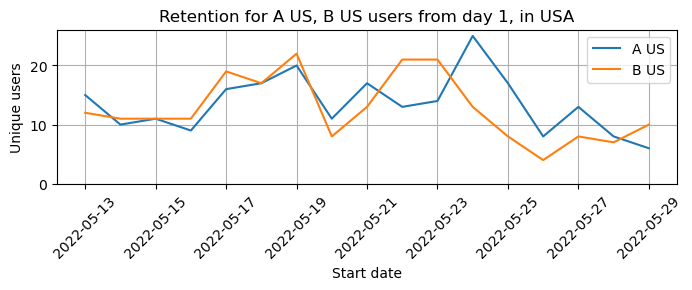

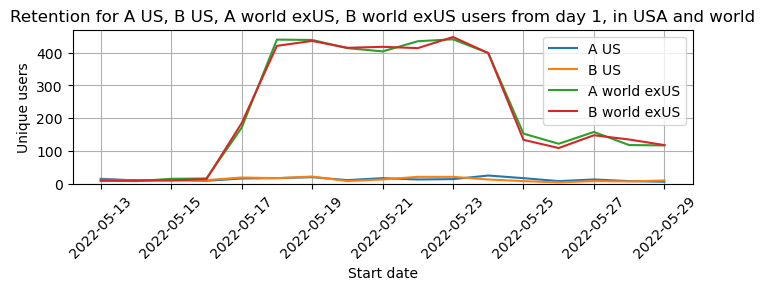

In [415]:
day_num = 1
plot_retention_one_day([A_exception_days, B_exception_days], ['A US', 'B US'], day_num, f', in USA', title=True)
# plot_retention_one_day([A_others_days, B_others_days], ['A world exUS', 'B world exUS'], day_num, f', in other countries', title=True)
plot_retention_one_day([A_exception_days, B_exception_days, A_others_days, B_others_days], ['A US', 'B US', 'A world exUS', 'B world exUS'], day_num, f', in USA and world', title=True)

We can see the high traffic we observed before on the heat map at Part 2. It's not a lot of users in US respective to exUS world, but enough for our calculations

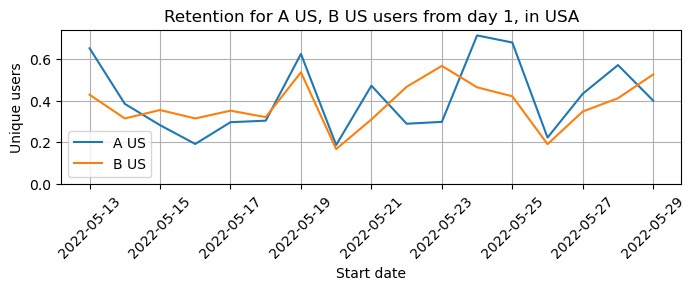

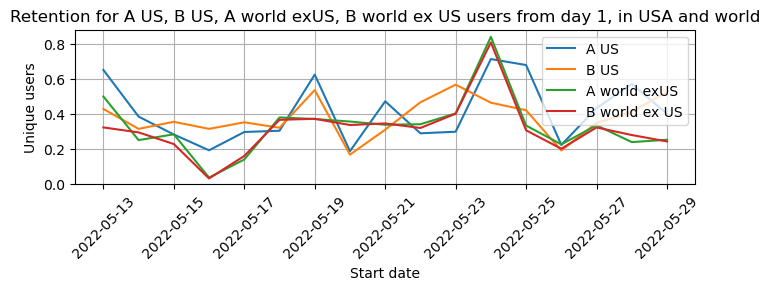

In [416]:
# same, normalized
day_num = 1
plot_retention_one_day([A_exception_days_norm, B_exception_days_norm], ['A US', 'B US'], day_num, ', in USA', title=True)
# plot_retention_one_day([A_others_days_norm, B_others_days_norm], ['A world exUS', 'B world ex US'], day_num, ', in other countries', title=True)
plot_retention_one_day([A_exception_days_norm, B_exception_days_norm, A_others_days_norm, B_others_days_norm], ['A US', 'B US', 'A world exUS', 'B world ex US'], day_num, ', in USA and world', title=True)

It's really hard to get conclusions from something looking like this, so statistical tests will help us here

## Mann–Whitney U tests <a class="anchor" id="tests"></a>
For ous statiscical tests will use Mann–Whitney non-parametric U test, two sided alternative, alpha = 0.05<br>
Will test every day A vs B, no more than week, to keep the numbers robust

In [417]:
# A_exception_days_norm

In [418]:
# option for some day in table with days
# USE NORMALIZED ONLY
def mwu_multytest_by_days(group_A, group_B):
    p_list = []
    print('For day 0 we don\'t calculate, it\'s the day the data normalized by') 
    for day in range(1, int(min(max(group_A.index), max(group_B.index), 8))):
        A_conf_df_raw = group_A[group_A.index == day]
        A_conf_df = pd.DataFrame({'event_date': A_conf_df_raw.columns.tolist(), 'Unique users': A_conf_df_raw.values[0]})
        B_conf_df_raw = group_B[group_B.index == day]
        B_conf_df = pd.DataFrame({'event_date': B_conf_df_raw.columns.tolist(), 'Unique users': B_conf_df_raw.values[0]})

        A = A_conf_df['Unique users'][day:-1] # -1 here to get rid from the last day - it incomplete and make it wrong
        B = B_conf_df['Unique users'][day:-1]
        
        # for tests
#         print(A, B)
#         plt.hist(A, alpha=.5)
#         plt.hist(B, alpha=.5)
#         plt.show()

        U1, p_value = stats.mannwhitneyu(A, B, alternative='two-sided')
        p_list.append(p_value)
        print(f'For day {day} p-value is', round(p_value, 3))   
    print()
    print('Average p-value is', round(statistics.mean(p_list), 2))
    print('Median  p-value is', round(statistics.median(p_list), 2))
    return p_list

***
Groups A/B in USA:

In [419]:
# Mann–Whitney U test by "age" in app
# For A and B in US
p_list = mwu_multytest_by_days(A_exception_days_norm, B_exception_days_norm)

For day 0 we don't calculate, it's the day the data normalized by
For day 1 p-value is 1.0
For day 2 p-value is 0.597
For day 3 p-value is 0.361
For day 4 p-value is 0.963
For day 5 p-value is 0.472
For day 6 p-value is 0.564
For day 7 p-value is 0.622

Average p-value is 0.65
Median  p-value is 0.6


***
Groups A/B it exUS world:

In [420]:
# For A and B in all other countries
p_list = mwu_multytest_by_days(A_others_days_norm, B_others_days_norm)

For day 0 we don't calculate, it's the day the data normalized by
For day 1 p-value is 0.558
For day 2 p-value is 0.665
For day 3 p-value is 0.74
For day 4 p-value is 0.982
For day 5 p-value is 0.837
For day 6 p-value is 0.977
For day 7 p-value is 0.743

Average p-value is 0.79
Median  p-value is 0.74


***
Groups A (old app), in US/exUS world:

In [421]:
# For A in US and A in other countries
p_list = mwu_multytest_by_days(A_exception_days_norm, A_others_days_norm)

For day 0 we don't calculate, it's the day the data normalized by
For day 1 p-value is 0.256
For day 2 p-value is 0.258
For day 3 p-value is 0.59
For day 4 p-value is 0.535
For day 5 p-value is 0.758
For day 6 p-value is 0.84
For day 7 p-value is 0.793

Average p-value is 0.58
Median  p-value is 0.59


***
Groups B (new app), in US/exUS world:

In [422]:
# For B in Us and B in other countries
p_list = mwu_multytest_by_days(B_exception_days_norm, B_others_days_norm)

For day 0 we don't calculate, it's the day the data normalized by
For day 1 p-value is 0.042
For day 2 p-value is 0.118
For day 3 p-value is 0.184
For day 4 p-value is 0.421
For day 5 p-value is 0.33
For day 6 p-value is 0.194
For day 7 p-value is 0.358

Average p-value is 0.24
Median  p-value is 0.19


We can say that there is no significant differences there, but it could be interesting that new app have much lower p-value than old app in comparing US/exUS world, still not under 0.05

## Device groups - Samsung vs 10 top after S. <a class="anchor" id="day_samto10"></a>

In [423]:
A_top_10, B_top_10, A_samsung, B_samsung = groups_all_and_exception_by_days(top_11, 'device_manufacturer', 'Samsung')

In [424]:
# def normalize_table_by_day_0(table):
#     return table.div(table[table.index == 0].values, axis=1)

In [425]:
# normalizing
A_top_10_norm = normalize_table_by_day_0(A_top_10)
B_top_10_norm = normalize_table_by_day_0(B_top_10)
A_samsung_norm = normalize_table_by_day_0(A_samsung)
B_samsung_norm = normalize_table_by_day_0(B_samsung)

In [426]:
# A_top_10 # to check 24.05 data

### Plots Samsung and Others by days<a class="anchor" id="day_sam_plots"></a>

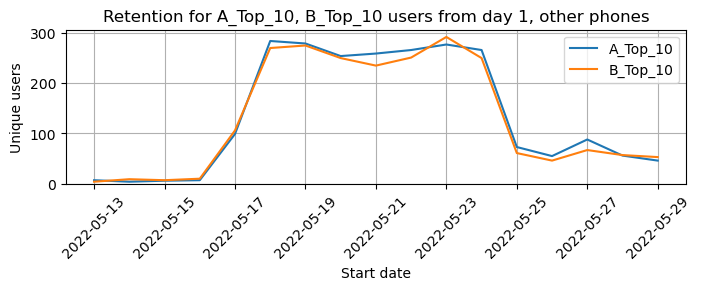

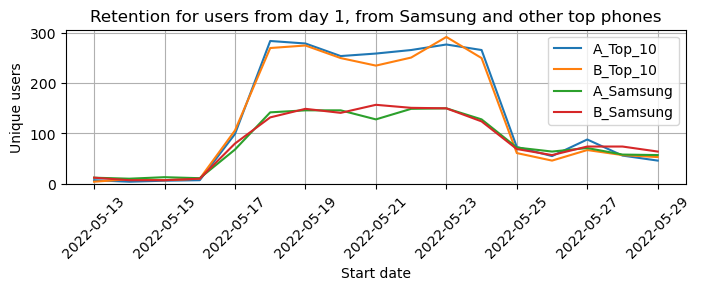

In [427]:
# plots for 10 top vs Samsung | Absolute
day_num = 1
plot_retention_one_day([A_top_10, B_top_10], ['A_Top_10', 'B_Top_10'], day_num, f', other phones', title=True)
plot_retention_one_day([ A_top_10, B_top_10, A_samsung, B_samsung], ['A_Top_10', 'B_Top_10', 'A_Samsung', 'B_Samsung'], day_num, f', from Samsung and other top phones', title=False)

Looks familiar, here we have hundreds of users for many days, it's good

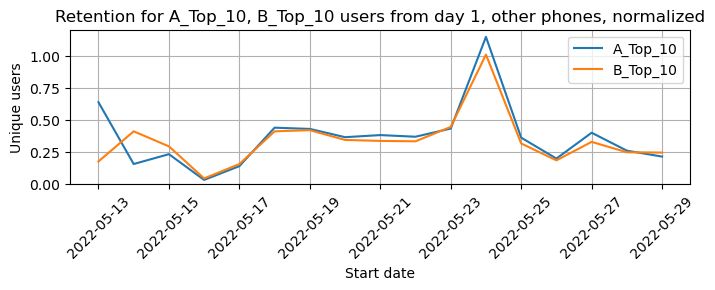

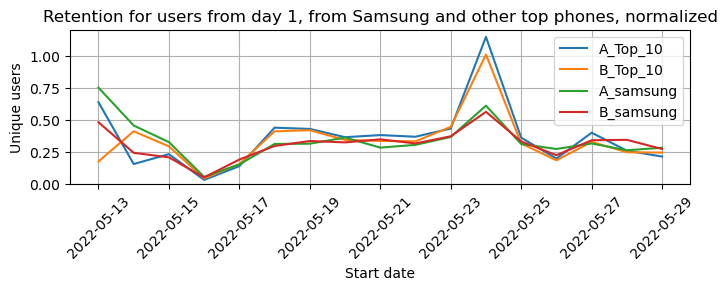

In [428]:
# plots for 10 top vs Samsung | Normalized
day_num = 1
plot_retention_one_day([A_top_10_norm, B_top_10_norm], ['A_Top_10', 'B_Top_10'], day_num, f', other phones, normalized', title=True)
plot_retention_one_day([A_top_10_norm, B_top_10_norm, A_samsung_norm, B_samsung_norm], ['A_Top_10', 'B_Top_10', 'A_samsung', 'B_samsung'], day_num, f', from Samsung and other top phones, normalized', title=False)

<i>There is some strange peak on 24, after check - that's the data we have, function calculates right</i>

### Statistical tests for Samsung vs 10 top after S.<a class="anchor" id="day_sam_tests"></a>

***
Samsung users A/B:

In [429]:
# For A_samsung, B_samsung 
p_list = mwu_multytest_by_days(A_samsung_norm, B_samsung_norm)

For day 0 we don't calculate, it's the day the data normalized by
For day 1 p-value is 0.986
For day 2 p-value is 0.572
For day 3 p-value is 0.901
For day 4 p-value is 0.982
For day 5 p-value is 0.878
For day 6 p-value is 0.507
For day 7 p-value is 0.393

Average p-value is 0.75
Median  p-value is 0.88


***
Top 10 after S. users A/B:

In [430]:
# For A_top_10, B_top_10 (other phones)
p_list = mwu_multytest_by_days(A_top_10_norm, B_top_10_norm)

For day 0 we don't calculate, it's the day the data normalized by
For day 1 p-value is 0.63
For day 2 p-value is 0.638
For day 3 p-value is 0.561
For day 4 p-value is 0.836
For day 5 p-value is 0.608
For day 6 p-value is 0.707
For day 7 p-value is 0.555

Average p-value is 0.65
Median  p-value is 0.63


***
Groups A, Samsung/Top 10 after S.:

In [431]:
# For A_samsung, A_top_10
p_list = mwu_multytest_by_days(A_samsung_norm, A_top_10_norm)

For day 0 we don't calculate, it's the day the data normalized by
For day 1 p-value is 0.783
For day 2 p-value is 0.955
For day 3 p-value is 0.507
For day 4 p-value is 0.73
For day 5 p-value is 0.72
For day 6 p-value is 0.507
For day 7 p-value is 0.393

Average p-value is 0.66
Median  p-value is 0.72


***
Groups B, Samsung/Top 10 after S.:

In [432]:
# For B_samsung, B_top_10
p_list = mwu_multytest_by_days(B_samsung_norm, B_top_10_norm)

For day 0 we don't calculate, it's the day the data normalized by
For day 1 p-value is 1.0
For day 2 p-value is 0.91
For day 3 p-value is 0.901
For day 4 p-value is 0.8
For day 5 p-value is 0.682
For day 6 p-value is 0.583
For day 7 p-value is 0.47

Average p-value is 0.76
Median  p-value is 0.8


## Conclusion<a class="anchor" id="conc_4"></a>
There is no significant difference between groups we observed, US/exUS or Samsung/Other brands<BR>
    There is some difference within group B (new app) US/exUs users, but p_value still too large - 0.1-0.2<BR>
    
Next step could be divide groups to subgroups, for example get only Samsung events and divide by country after it

## Part 4.1. Explore Samsung group by countries <a class="anchor" id="samsung_part"></a>
<b>Steps are:</b>
* Filter Samsung events from all set
* Explore the data dividing by countries with developed toolset
* Plot graphs
* Make statistical tests

Will use the table filtered before:

In [433]:
can_show(samsung_only.head(3))

level_number appmetrica_device_id      event_datetime device_manufacturer  \
0          36.0            000000000 2022-05-30 00:08:42             Samsung   
1          37.0            000000000 2022-05-30 00:18:13             Samsung   
2          37.0            000000000 2022-05-30 00:23:37             Samsung   

  country_iso_code  app_version_name event_date start_date  user_age_in_app  \
0               AR              23.0 2022-05-30 2022-05-29              1.0   
1               AR              23.0 2022-05-30 2022-05-29              1.0   
2               AR              23.0 2022-05-30 2022-05-29              1.0   

  hour          start_time  user_time_in_app  
0   00 2022-05-29 03:35:31         20.553056  
1   00 2022-05-29 03:35:31         20.711667  
2   00 2022-05-29 03:35:31         20.801667

Number of unique users in Samsung table:

In [434]:
# unique users - Samsung
samsung_only.appmetrica_device_id.nunique()

10788

Get groups to plot ant test:

In [435]:
A_others, B_others, A_exception, B_exception = groups_all_and_exception_by_days(samsung_only, 'country_iso_code', 'US')

In [436]:
# normalization
[A_others_norm, B_others_norm, A_exception_norm, B_exception_norm] = \
[normalize_table_by_day_0(x) for x in [A_others, B_others, A_exception, B_exception]]

In [437]:
# A_others
# B_others
# A_exception
# B_exception

In [438]:
# A_others_norm
# B_exception#_norm

#### Plots for Samsung group<a class="anchor" id="sam_plots"></a>

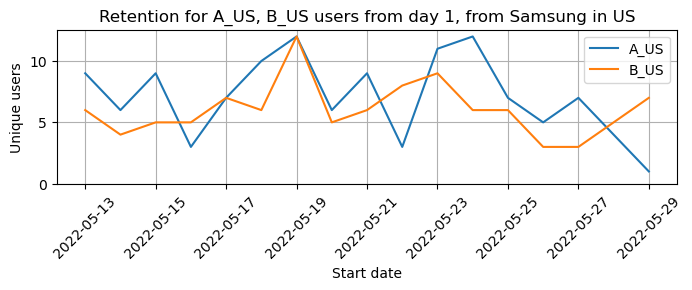

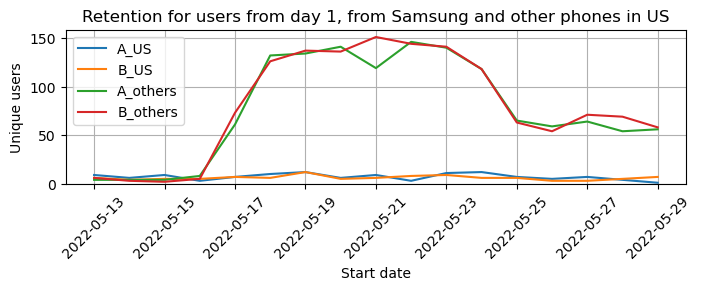

In [439]:
# Absolute values
day_num = 1
plot_retention_one_day([A_exception, B_exception], ['A_US', 'B_US'], day_num, ', from Samsung in US', title=True)
# plot_retention_one_day([A_others, B_others], ['A_others', 'B_others'], day_num, ', other phones in US', title=True)
plot_retention_one_day([A_exception, B_exception, A_others, B_others], ['A_US', 'B_US', 'A_others', 'B_others'], day_num, ', from Samsung and other phones in US', title=False)

If for Other countries within Samsung are hundreds of users, for US are only dozens, so comparing with US will be less robust, just will keep it in mind

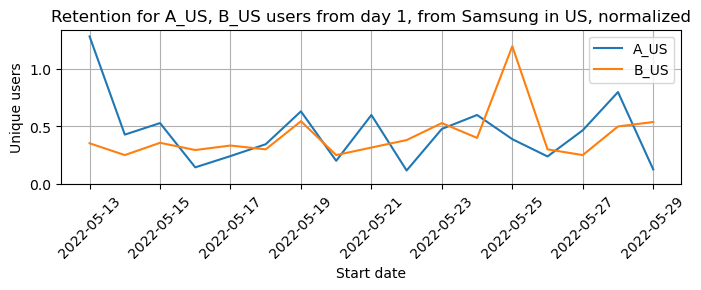

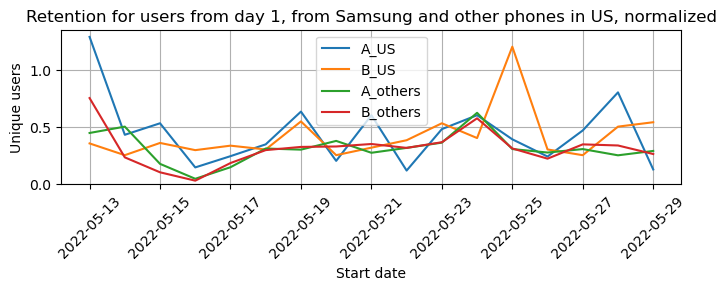

In [440]:
# Normalized values
day_num = 1
plot_retention_one_day([A_exception_norm, B_exception_norm], ['A_US', 'B_US'], day_num, ', from Samsung in US, normalized', title=True)
# plot_retention_one_day([A_others_norm, B_others_norm], ['A_others', 'B_others'], day_num, ', other phones in US, normalized', title=True)
plot_retention_one_day([A_exception_norm, B_exception_norm, A_others_norm, B_others_norm], ['A_US', 'B_US', 'A_others', 'B_others'], day_num, ', from Samsung and other phones in US, normalized', title=False)

<i>The peak on 25.05 and value over 1.0 at 13.05 really received from our data, everything is right in calculating function</i>

#### Mann–Whitney U tests for Samsung users (S) <a class="anchor" id="sam_tests"></a>

***
US users, A/B (S):

In [441]:
# For A and B in US
p_list = mwu_multytest_by_days(A_exception_norm, B_exception_norm)

For day 0 we don't calculate, it's the day the data normalized by
For day 1 p-value is 0.877
For day 2 p-value is 0.836
For day 3 p-value is 0.493
For day 4 p-value is 0.198
For day 5 p-value is 0.081
For day 6 p-value is 0.603
For day 7 p-value is 0.176

Average p-value is 0.47
Median  p-value is 0.49


***
exUS world users, A/B (S):

In [442]:
# For A and B other contries
p_list = mwu_multytest_by_days(A_others_norm, B_others_norm)

For day 0 we don't calculate, it's the day the data normalized by
For day 1 p-value is 0.89
For day 2 p-value is 0.749
For day 3 p-value is 0.983
For day 4 p-value is 0.908
For day 5 p-value is 0.878
For day 6 p-value is 0.525
For day 7 p-value is 0.646

Average p-value is 0.8
Median  p-value is 0.88


***
Groups A, US/exUS world (S):

In [443]:
# For A US and A in other countries
p_list = mwu_multytest_by_days(A_exception_norm, A_others_norm)

For day 0 we don't calculate, it's the day the data normalized by
For day 1 p-value is 0.215
For day 2 p-value is 0.105
For day 3 p-value is 0.468
For day 4 p-value is 0.346
For day 5 p-value is 0.918
For day 6 p-value is 0.236
For day 7 p-value is 0.511

Average p-value is 0.4
Median  p-value is 0.35


***
Groups B, US/exUS world (S):

In [444]:
# there was 0.06-0.08 before 7 days limit
# For B US and B other countries
p_list = mwu_multytest_by_days(B_exception_norm, B_others_norm)

For day 0 we don't calculate, it's the day the data normalized by
For day 1 p-value is 0.121
For day 2 p-value is 0.046
For day 3 p-value is 0.101
For day 4 p-value is 0.036
For day 5 p-value is 0.072
For day 6 p-value is 0.285
For day 7 p-value is 0.094

Average p-value is 0.11
Median  p-value is 0.09



Something maybe happening here, but the numbers are revalively low and effect is more between US/exUS than between groups A/B. Let's summarize those groups to get more robust data and check namely US/exUS


We want to be sure that our calculations of p-value based on appropriate data.<br> Will check how many users (in smallest group) we take from every day:

In [445]:
exception = A_exception + B_exception
days = range(0, 8)
print('Number of users with "age" in app:')
for day in days:
    print(f'Day {day}:', exception[day:day].sum().sum())

Number of users with "age" in app:
Day 0: 623.0
Day 1: 227.0
Day 2: 157.0
Day 3: 110.0
Day 4: 96.0
Day 5: 71.0
Day 6: 65.0
Day 7: 53.0


It's about dozens and hundreds, approved for calculations!

***
US/exUS:

In [446]:
US_norm = A_exception_norm + B_exception_norm
exUS_norm = A_others_norm + B_others_norm
# For all US vs all other countries
p_list = mwu_multytest_by_days(US_norm, exUS_norm)

For day 0 we don't calculate, it's the day the data normalized by
For day 1 p-value is 0.098
For day 2 p-value is 0.036
For day 3 p-value is 0.158
For day 4 p-value is 0.033
For day 5 p-value is 0.137
For day 6 p-value is 0.194
For day 7 p-value is 0.168

Average p-value is 0.12
Median  p-value is 0.14


Of course p-value in this case is bigger, but also we have much more users and can trust this result more.

### Conclusion <a class="anchor" id="sam_conc"></a>
We observed Samsung users group:<br>
Again there is no significant difference between most subgroups we observed<BR>
But p-values we observe now between subgroups US and exUS are lower than in most of tests. Sometimes even less than 0.05. We can't say that find something here, but it could be possible that there is another subgroup inside, with really low p-values. <br>
Also we can add, that differences between versions are not so important like belonging to US or exUS countries.

# Part 5. Retention heat maps<a class="anchor" id="heat_maps"></a>
heat map plot is very readable way to show retentions for cohorts. We can observe multiple cohorts simultaneously, understand dynamics by time. <br>In this part we have: 
* Retention heat maps for all users
* Retention heat maps for Exception vs Others
* Retention differences by heat maps
* Set of retention heat maps for Samsung users only

In [447]:
# group ALL users by dates
def to_heat mapable_df(df):
    grouped_by_dates = df.groupby(['start_date', 'event_date'], as_index=False)['appmetrica_device_id'].nunique()
    grouped_by_dates.rename(columns={'appmetrica_device_id':'Unique users'}, inplace=True)
    # get rid of users insalled app days before play level one 
#     grouped_by_dates = grouped_by_dates[grouped_by_dates.start_date <= grouped_by_dates.event_date]
    grouped_by_dates_pvt = grouped_by_dates.pivot(index='start_date', columns='event_date', values='Unique users')
    grouped_by_dates_pvt = grouped_by_dates_pvt.fillna(0).astype(int)
    return grouped_by_dates_pvt

In [448]:
# normalize the table by rows
def normalize_table_rows(table):
    return table.div(table.max(axis=1), axis=0) # [0,1]
#     return table.apply(lambda x: (x-x.mean())/x.std(), axis = 1) # [std]

## Retention heat maps for all users <a class="anchor" id="hm_all_users"></a>

### Construct the table <a class="anchor" id="table_cons"></a>

In [449]:
# test function on all data
hm_all = to_heat mapable_df(globe_normal)
hm_all

event_date  2022-05-12  2022-05-13  2022-05-14  2022-05-15  2022-05-16  \
start_date                                                               
2022-05-12         114          45          28          25          18   
2022-05-13           3         100          39          33          22   
2022-05-14           4           5         127          47          35   
2022-05-15           1           1           1         167          50   
2022-05-16           1           1           0           1         999   
2022-05-17           5           2           1           2          13   
2022-05-18           1           2           1           2           9   
2022-05-19           4           1           0           0           4   
2022-05-20           2           1           2           3           6   
2022-05-21           3           0           0           1           5   
2022-05-22           1           1           1           0           2   
2022-05-23           1           1           1           1           0   
2022-05-24           0           3           2           2           1   
2022-05-25           2           1           1           1           2   
2022-05-26           0           1           0           0           0   
2022-05-27           1           1           1           1           1   
2022-05-28           1           2           1           1           0   
2022-05-29           0           0           0           1           2   
2022-05-30           0           0           0           0           0   

event_date  2022-05-17  2022-05-18  2022-05-19  2022-05-20  2022-05-21  \
start_date                                                               
2022-05-12          18          11          10          11          12   
2022-05-13          20          18          21          13          19   
2022-05-14          28          22          21          16          20   
2022-05-15          37          25          23          19          19   
2022-05-16         390         245         158         131         113   
2022-05-17        2494         892         612         473         408   
2022-05-18          28        2411         915         616         504   
2022-05-19          17          22        2424         845         550   
2022-05-20           7          13          17        2497         849   
2022-05-21           7           7           8          11        2481   
2022-05-22           6           7           7           7          17   
2022-05-23           0           0           0           0           1   
2022-05-24           1           1           0           0           0   
2022-05-25           2           3           4           3           3   
2022-05-26           0           1           3           7           8   
2022-05-27           1           1           2           7          10   
2022-05-28           1           1           1           1           7   
2022-05-29           0           0           1           2           1   
2022-05-30           0           0           0           0           0   

event_date  2022-05-22  2022-05-23  2022-05-24  2022-05-25  2022-05-26  \
start_date                                                               
2022-05-12          11          11          10           8          10   
2022-05-13          17          15          13          16           9   
2022-05-14          19          17          13          17          12   
2022-05-15          20          14          17          20          12   
2022-05-16          98          89          88          83          68   
2022-05-17         344         315         282         275         247   
2022-05-18         418         352         317         290         251   
2022-05-19         466         387         334         293         265   
2022-05-20         610         478         400         329         284   
2022-05-21         880         602         460         369         308   
20

In [450]:
hm_all_norm = normalize_table_rows(hm_all)
# hm_all_norm

In [451]:
def plot_heat map(df, normal=True, label=None):
    plt.subplots(figsize=(8, 8))
    color_scheme = 'YlGnBu'
    if normal:
        # calculate
        df_norm=normalize_table_rows(df)
        st_dev_norm = df_norm.values.std()
        
        # set colors and format
        color_scheme = 'viridis'
        
        # plot
        ax = sns.heat map(data=df_norm, annot=True, fmt='.1%', vmin=0, vmax=st_dev_norm, cmap=color_scheme, annot_kws={"size":6})
    else:
        # calculate
        st_dev = df.values.std()
        # plot
        ax = sns.heat map(data=df, annot=True, fmt='d', vmin=0, vmax=st_dev, cmap=color_scheme, annot_kws={"size":7.5})

    #set readable labels
    x_ticklabels = [df.index[int(tick)].strftime('%Y-%m-%d') for tick in ax.get_xticks()]
    ax.set_xticklabels(x_ticklabels)
    y_ticklabels = [df.index[int(tick)].strftime('%Y-%m-%d') for tick in ax.get_yticks()] # can remove it but will be for robust system
    ax.set_yticklabels(y_ticklabels)
    plt.xlabel('Event date')
    plt.ylabel('Start date')
    plt.title(label)
    
    plt.tight_layout()
    plt.show()

### Plot heat maps <a class="anchor" id="hm_global"></a>

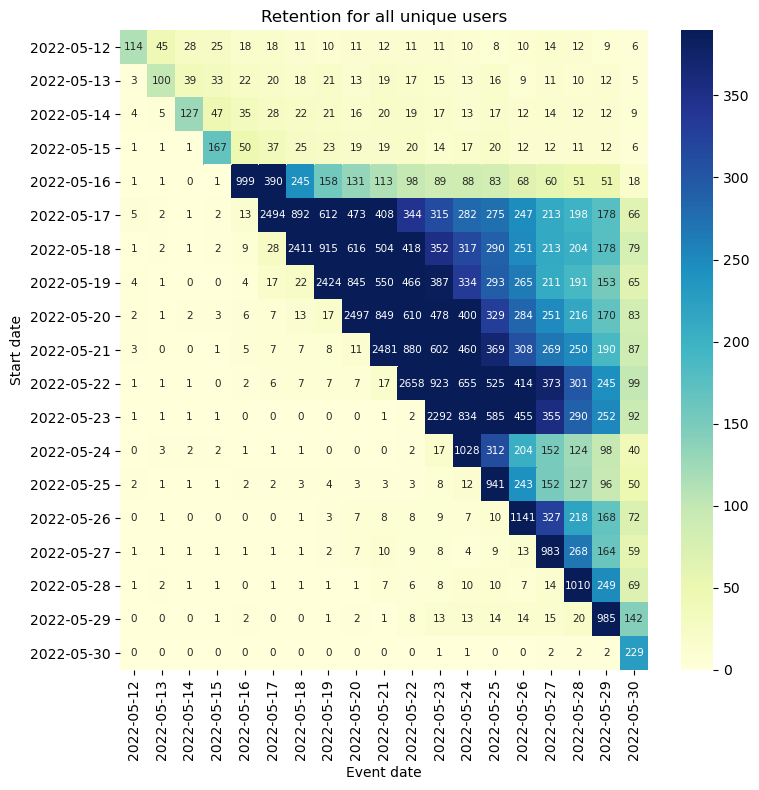

In [452]:
# plot simple heat map from data
plot_heat map(hm_all, normal=False, label='Retention for all unique users')

Some days cohorts are different, we can check how it correspondents to campaigns or another actions influenced our traffic<br>For example the days with increased traffic standing out<br>
<i>* last day is not completed<i>

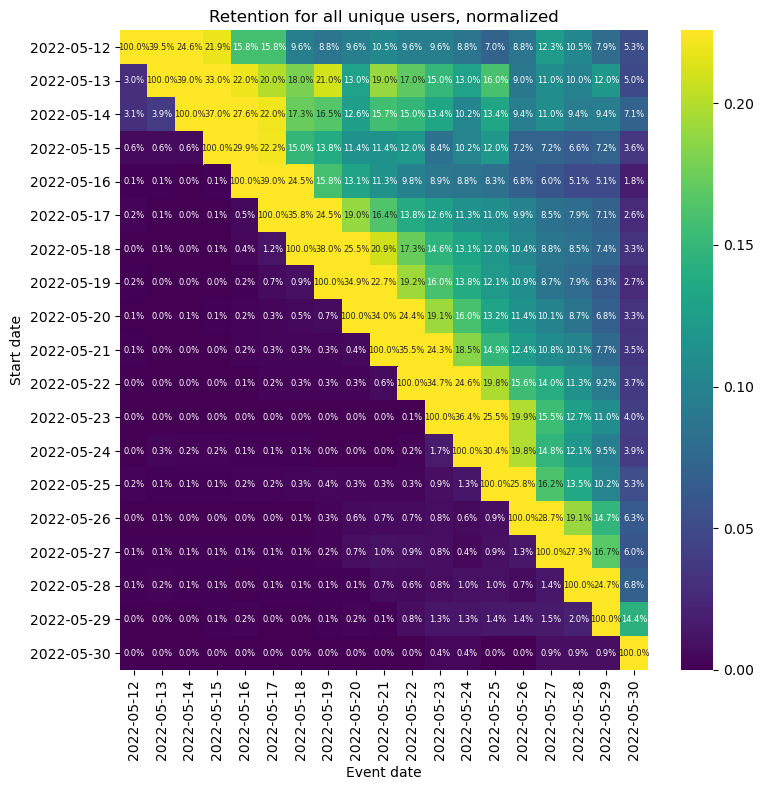

In [453]:
# plot simple heat map from data NORMALIZED
plot_heat map(hm_all, normal=True, label='Retention for all unique users, normalized')

Here we adjusted a colormap - maximum (yellow) is one standart deviation for now, to emphasize the differences by time.<br>

<i>* last day is not completed<i>

## heat maps for Exception vs Others <a class="anchor" id="hm_ex_others"></a>
Earlier we observed retention graphs for different groups, for example A/B groups in US/exUS world. Will plot retention heat maps for those groups

In [454]:
# function to get all in category, except one for heat map (for All/USA and All/Samsung compare for example)
def all_and_exception_hm(globe_normal, column, exception):
    
    # All except one
    # filter all without exception
    df_others = globe_normal[globe_normal[column] != exception]
    # filter by app_version_name
    df_others_a, df_others_b = split_ab(df_others)
    # get retention
    hm_others_a = to_heat mapable_df(df_others_a)
    hm_others_b = to_heat mapable_df(df_others_b)
    # no balance here
    
    # Exception
    # filter exception only
    df_exception = globe_normal[globe_normal[column] == exception]
    # filter by app_version_name
    df_exception_a, df_exception_b = split_ab(df_exception)
    # get retention
    hm_exception_a = to_heat mapable_df(df_exception_a)
    hm_exception_b = to_heat mapable_df(df_exception_b)

    return hm_others_a, hm_others_b, hm_exception_a, hm_exception_b

In [455]:
category = 'country_iso_code'
marker = 'US'
hm_others_a, hm_others_b, hm_exception_a, hm_exception_b = all_and_exception_hm(globe_normal, category, marker)

<b>The data for heat maps</b>

In [456]:
hm_others_a

event_date  2022-05-12  2022-05-13  2022-05-14  2022-05-15  2022-05-16  \
start_date                                                               
2022-05-12          32           9           8           6           1   
2022-05-13           0          18           8           7           5   
2022-05-14           0           0          32          15          10   
2022-05-15           1           0           1          53          16   
2022-05-16           0           0           0           1         454   
2022-05-17           3           1           1           0           5   
2022-05-18           1           2           1           1           5   
2022-05-19           1           0           0           0           2   
2022-05-20           0           0           0           2           3   
2022-05-21           3           0           0           1           2   
2022-05-22           0           0           0           0           0   
2022-05-23           1           0           1           1           0   
2022-05-24           0           3           2           2           1   
2022-05-25           2           1           0           0           0   
2022-05-26           0           1           0           0           0   
2022-05-27           0           0           0           0           0   
2022-05-28           1           1           0           0           0   
2022-05-29           0           0           0           1           1   
2022-05-30           0           0           0           0           0   

event_date  2022-05-17  2022-05-18  2022-05-19  2022-05-20  2022-05-21  \
start_date                                                               
2022-05-12           4           2           2           2           1   
2022-05-13           1           2           3           2           2   
2022-05-14           8           4           6           4           7   
2022-05-15          14          11          13          11           8   
2022-05-16         171         111          74          62          59   
2022-05-17        1231         440         302         248         215   
2022-05-18          14        1159         439         308         263   
2022-05-19           9          10        1184         414         272   
2022-05-20           2           3           4        1162         404   
2022-05-21           3           4           3           3        1196   
2022-05-22           1           3           2           3           6   
2022-05-23           0           0           0           0           1   
2022-05-24           1           1           0           0           0   
2022-05-25           0           1           2           1           2   
2022-05-26           0           1           2           5           3   
2022-05-27           0           0           0           5           6   
2022-05-28           0           0           0           0           2   
2022-05-29           0           0           1           1           1   
2022-05-30           0           0           0           0           0   

event_date  2022-05-22  2022-05-23  2022-05-24  2022-05-25  2022-05-26  \
start_date                                                               
2022-05-12           1           0           1           1           3   
2022-05-13           3           3           2           3           0   
2022-05-14           6           4           4           2           4   
2022-05-15          10           9           9          12           8   
2022-05-16          41          36          39          38          29   
2022-05-17         170         159         143         136         122   
2022-05-18         206         179         160         151         125   
2022-05-19         239         197         164         153         130   
2022-05-20         293         234         189         171         135   
2022-05-21         435         292         240         188         165   
20

In [457]:
# hm_others_b

In [458]:
# hm_exception_a

In [459]:
# hm_exception_b

In [460]:
# normalize_table_rows(hm_exception_b)

In [461]:
# hm_others_a.values.std()

### Plot heat maps (Cartesian product of A/B, Exception/Others) <a class="anchor" id="hm_plot"></a>

In [462]:
def plot_4_heat maps(hm_others_a, hm_others_b, hm_exception_a, hm_exception_b, normal, labels=None):
    df_list = [hm_others_a, hm_others_b, hm_exception_a, hm_exception_b]
    plt.subplots(2, 2, figsize=(18, 18))
    color_scheme = 'YlGnBu'
    
    if labels == None:
        labels = ['Others A', 'Others B', 'Exception A', 'Exception B']

    for i in range(4):
        plt.subplot(2, 2, i+1)
        if normal:
            color_scheme = 'viridis'
            table=normalize_table_rows(df_list[i])
            ax = sns.heat map(data=table, annot=True, fmt='.1%', cmap=color_scheme, annot_kws={"size":7})
        else:
            if i%2 == 0:
                st_dev = df_list[i].values.std() # adjust scale for two heat maps   
            ax = sns.heat map(data=df_list[i], annot=True, fmt='d', vmin=0, vmax=st_dev, cmap=color_scheme, annot_kws={"size":8})
        #set readable labels
        # ticklabels = ['' for tick in ax.get_yticks()]
        x_ticklabels = [hm_others_a.index[int(tick)].strftime('%Y-%m-%d') for tick in ax.get_xticks()]
        ax.set_xticklabels(x_ticklabels)
        y_ticklabels = [hm_others_a.index[int(tick)].strftime('%Y-%m-%d') for tick in ax.get_yticks()] # can remove it but will be for robust system
        ax.set_yticklabels(y_ticklabels)
        plt.xlabel('Event date')
        plt.ylabel('Start date')
        plt.title(labels[i])
    
    plt.tight_layout()
    plt.show()

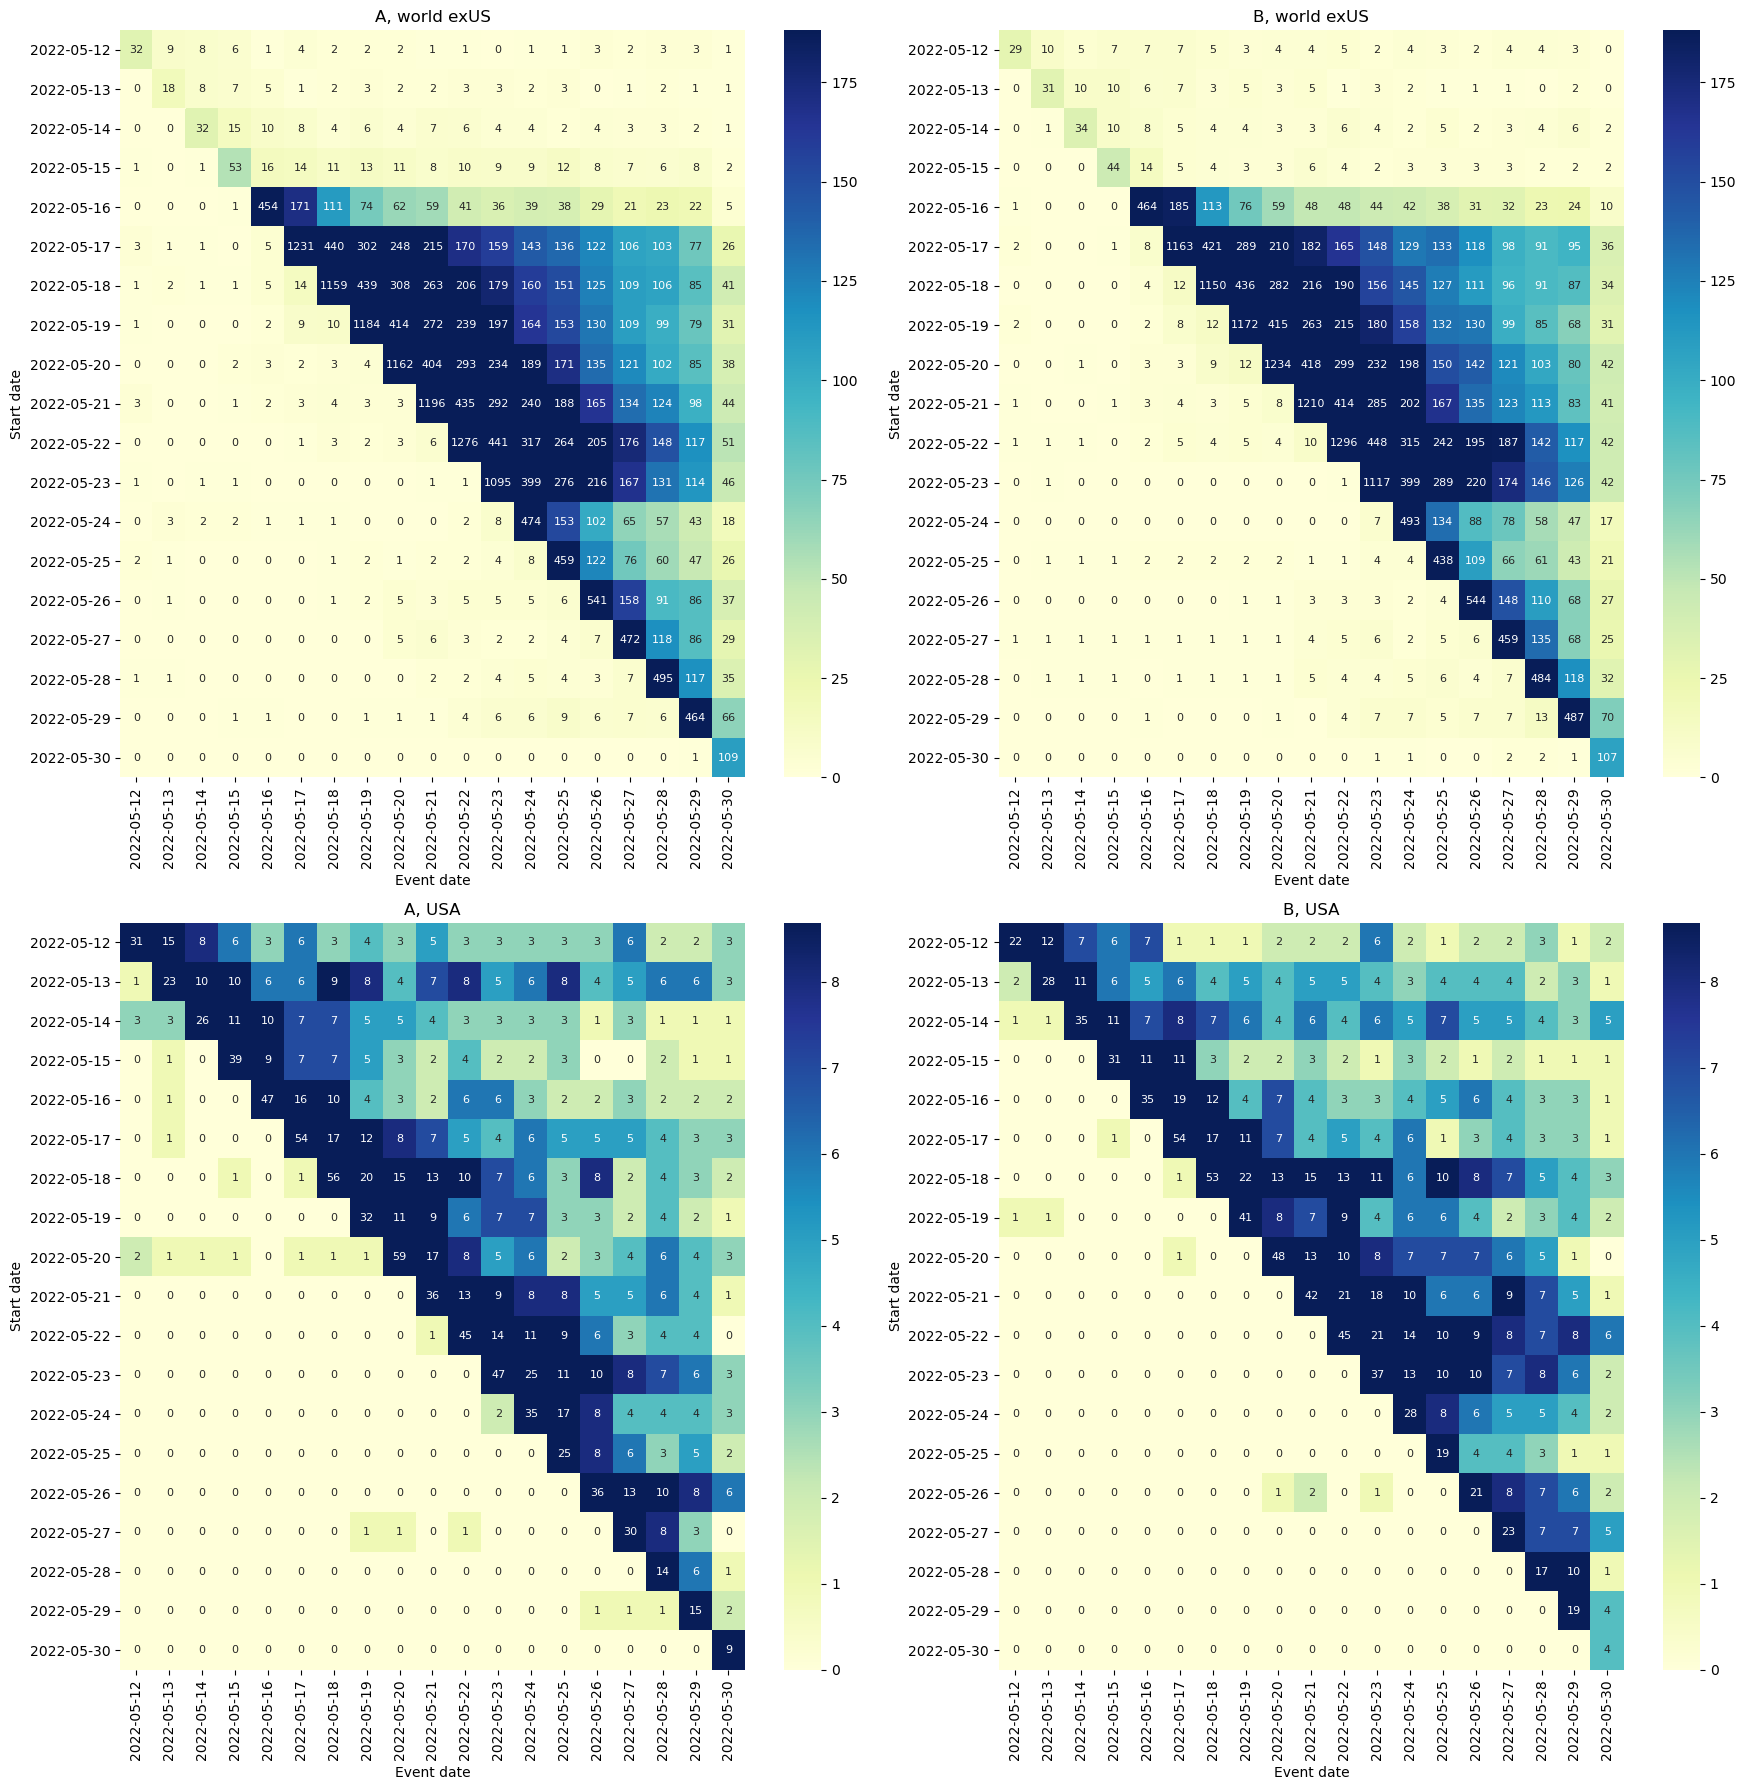

In [463]:
# plot_4_heat maps(hm_others_a, hm_others_b, hm_exception_a, hm_exception_b)
labels = ['A, world exUS', 'B, world exUS', 'A, USA', 'B, USA']
plot_4_heat maps(hm_others_a, hm_others_b, hm_exception_a, hm_exception_b, normal=False, labels=labels)

The heat map for exUS world looks lie a general retention heapmap, no surprises here. Also almost no difference between groups A/B. In US it's different, groups A/B looking more different, there is number of days with lower retention and number with higher, it can correlate with our different marketing actions. Another thing we keep in mind is lower total number of unique users here.

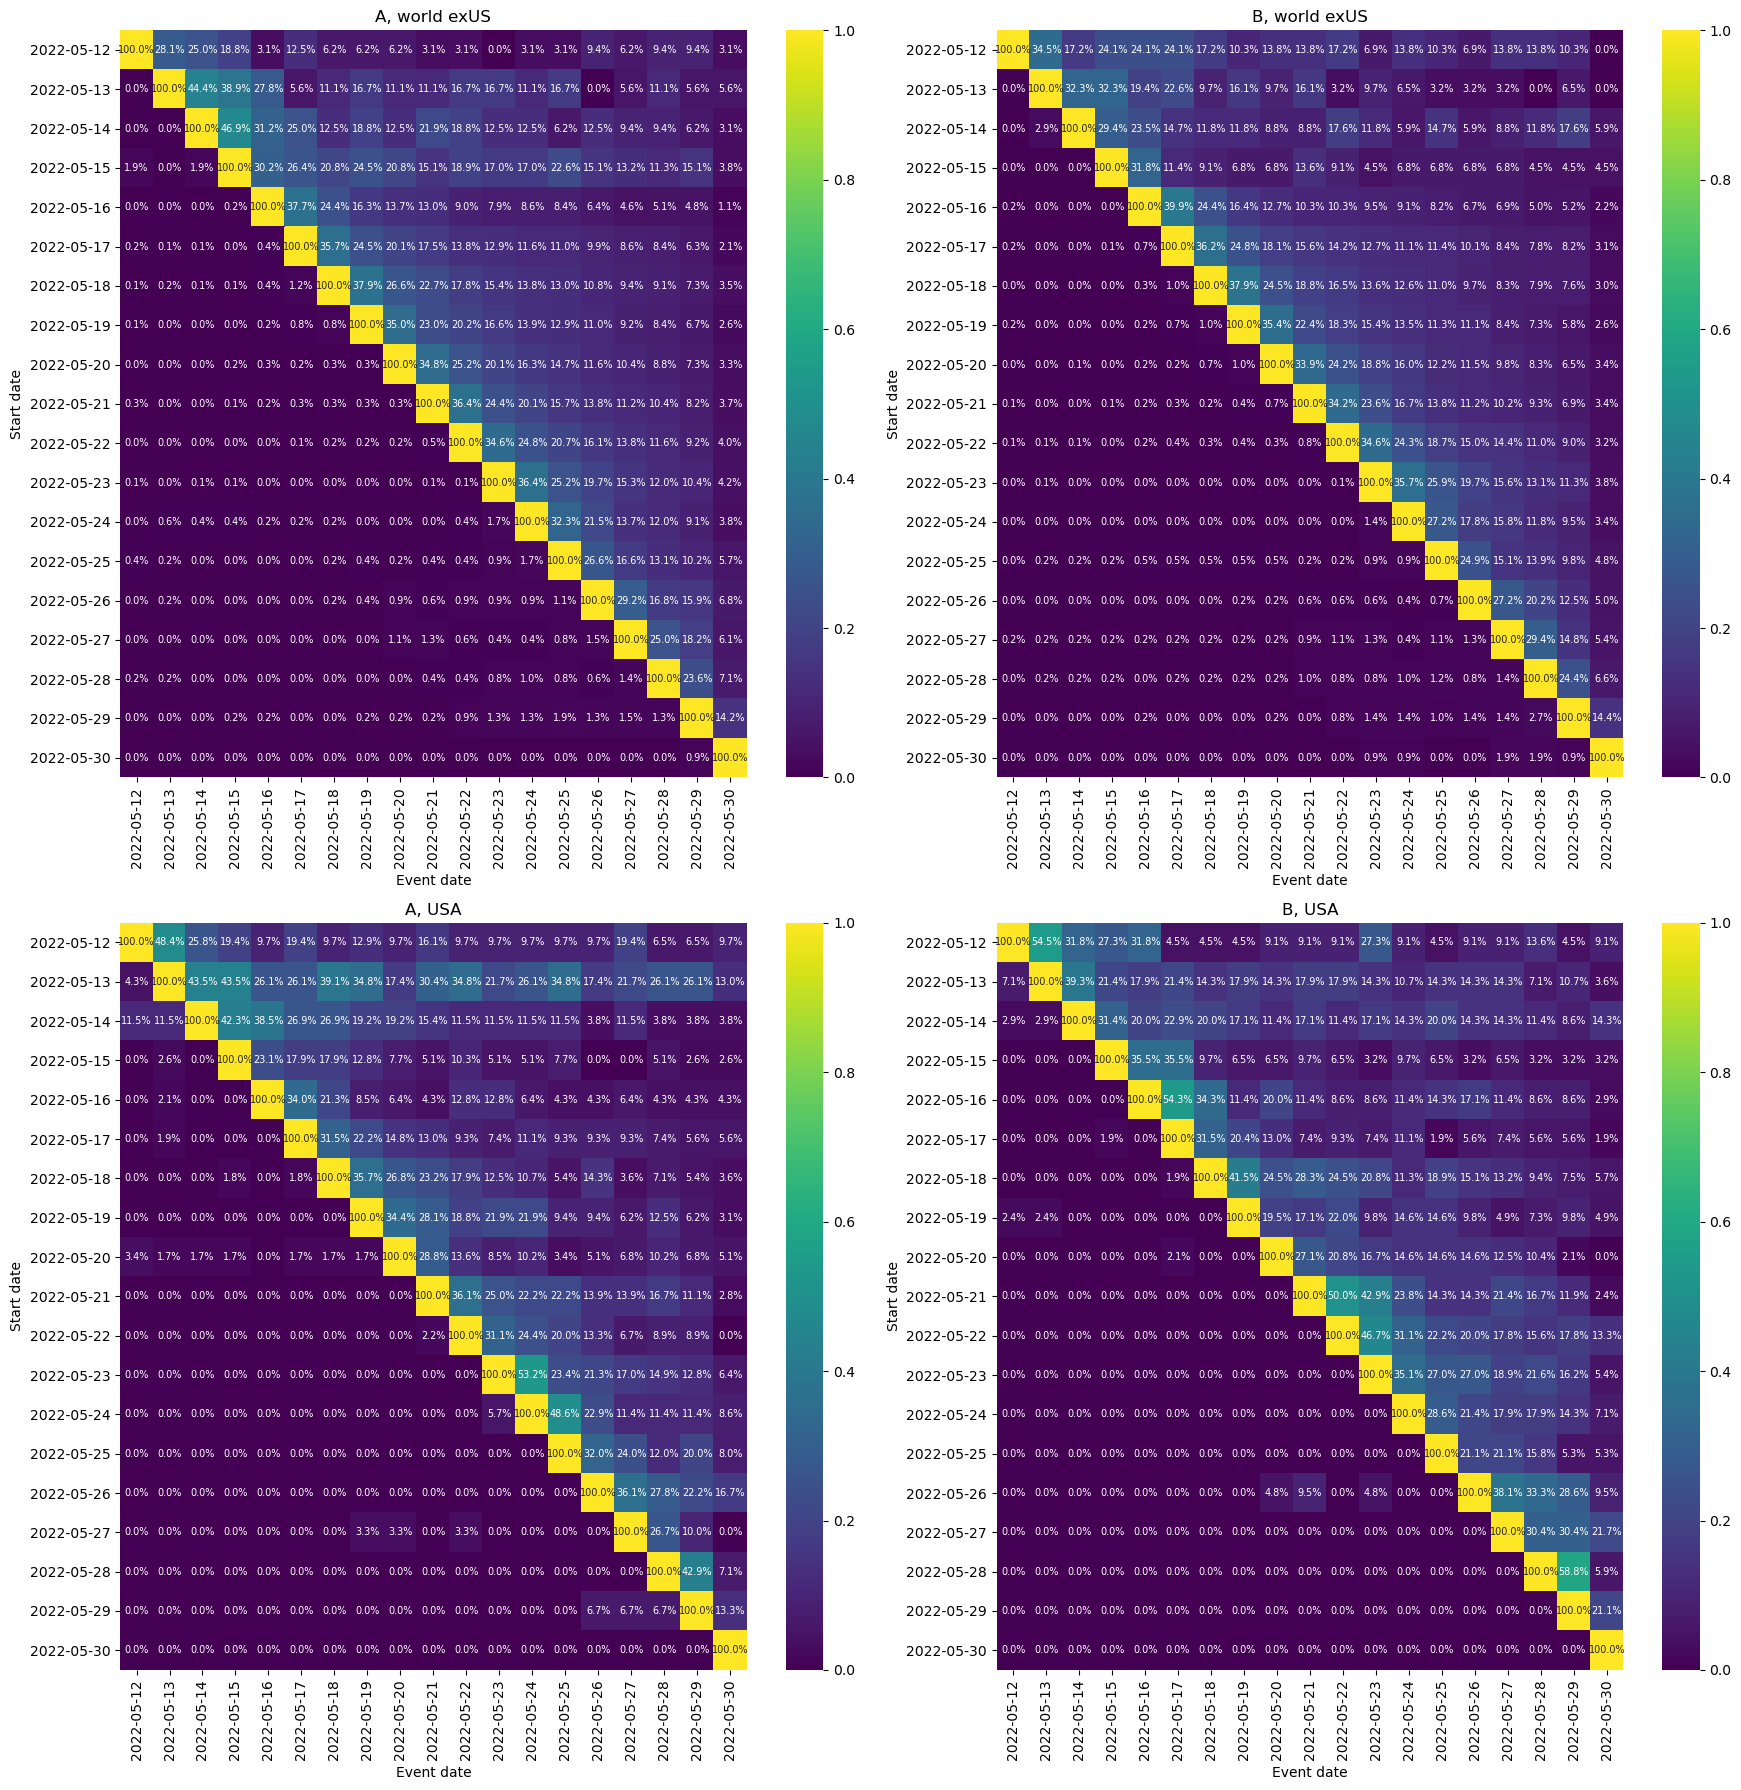

In [464]:
plot_4_heat maps(hm_others_a, hm_others_b, hm_exception_a, hm_exception_b, normal=True, labels=labels)

Looking at the normalized by first day plot much easier to spot and compare interesting days. We can see a number of days for version B, where retention is pretty high at first day (installation is day 0)
<br>
Looking at two groups like this can be interesting, but it's hard to compare. Showing the difference would provide more meaning and insights

### The differences by heat maps <a class="anchor" id="hm_diff"></a>

### Set palette

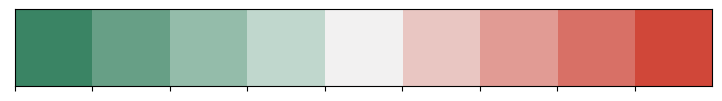

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

In [465]:
# Choose palette to plot differences
sns.choose_diverging_palette(sns.palplot(sns.diverging_palette(150, 15, n=9)))
plt.show()

### Plot difference heat maps <a class="anchor" id="hm_diff_plot"></a>

In [466]:
def plot_diff_heat maps(hm_others_a, hm_others_b, normal=True, label=None):
    
    plt.subplots(figsize=(8, 8))
    color_scheme = sns.diverging_palette(15, 150, n=9)#"YlGnBu"
    if label == None:
        label = 'Subtraction result: A - B'
    if normal:
        # calculate
        norm_difference = normalize_table_rows(hm_others_a) - normalize_table_rows(hm_others_b)
        st_dev_norm = norm_difference.values.std()
        # set colors and format
        color_scheme = sns.diverging_palette(5, 250, n=9)
        fmt = '.1%'
#         fmt='.2f'
        # plot
        ax = sns.heat map(data=norm_difference, annot=True, fmt=fmt, vmin=-st_dev_norm, vmax=st_dev_norm, center=0, cmap=color_scheme, annot_kws={"size":5.5})
        # upd label
        label = label + ', normalized'
    else:
        # calculate
        df_difference = hm_others_a - hm_others_b
        st_dev = df_difference.values.std()
        # plot
        ax = sns.heat map(data=df_difference, annot=True, fmt='d', vmin=-st_dev*3, vmax=st_dev*3, center=0, cmap=color_scheme)

    #set readable labels
    x_ticklabels = [hm_others_a.index[int(tick)].strftime('%Y-%m-%d') for tick in ax.get_xticks()]
    ax.set_xticklabels(x_ticklabels)
    y_ticklabels = [hm_others_a.index[int(tick)].strftime('%Y-%m-%d') for tick in ax.get_yticks()] # can remove it but will be for robust system
    ax.set_yticklabels(y_ticklabels)
    plt.xlabel('Event date')
    plt.ylabel('Start date')
    plt.title(label)

    plt.show()

<b>Absolute values</b>

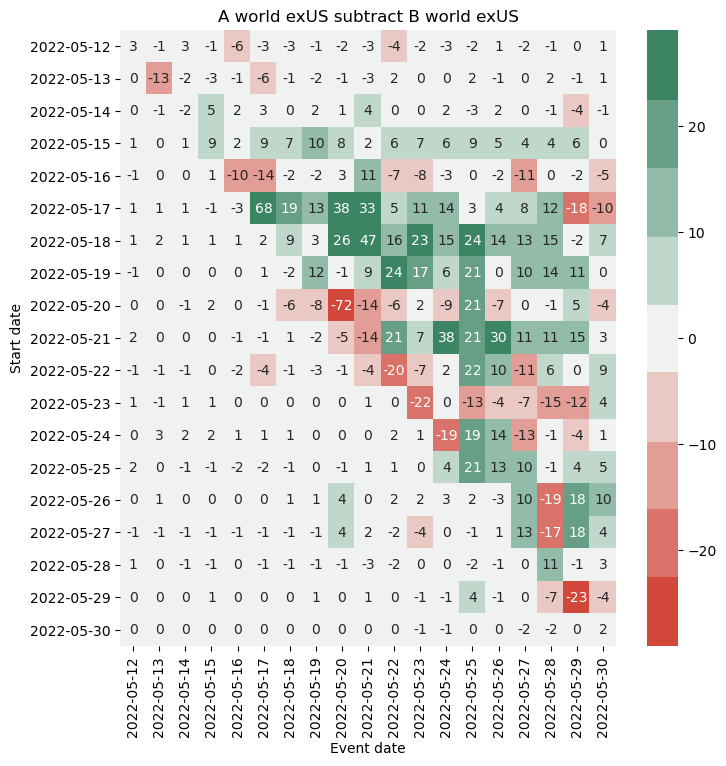

In [467]:
# absolute difference
label='A world exUS subtract B world exUS'
plot_diff_heat maps(hm_others_a, hm_others_b, normal=False, label=label) # Label None for test

Start dates 15.05 and 20.05 looking interesting here. Let's look at 20.05 (more date there), it was Friday, looks like we get more new users in group B (new version), but they churned after the day of installation, could be good to check the source of those users.<br>
<i>The color scale adjusted by one sigma limit</i>

<b>Normalized values</b>

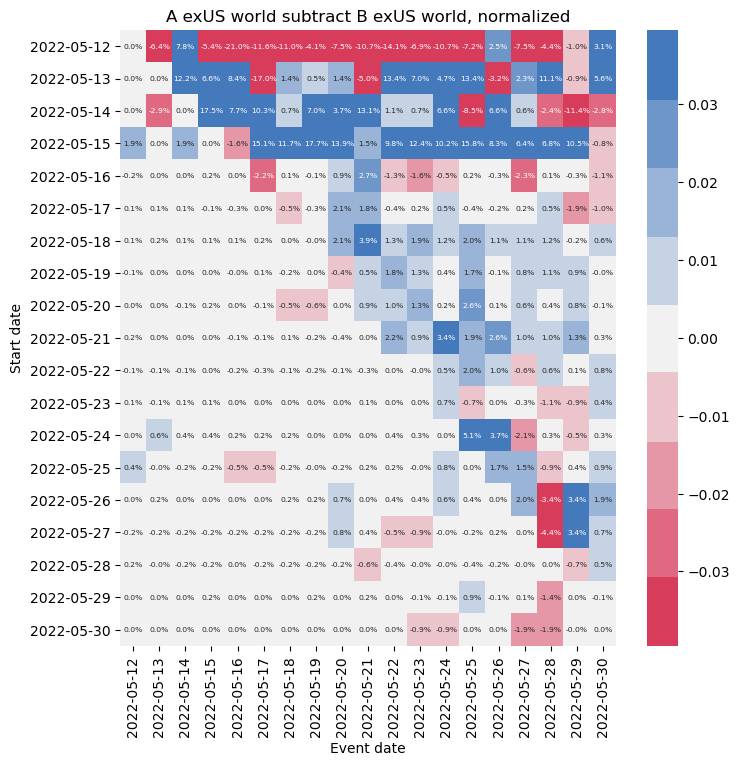

In [469]:
# difference of normalized tables
label='A exUS world subtract B exUS world'
plot_diff_heat maps(hm_others_a, hm_others_b, normal=True, label=label) 

The starting date 15.05 is distingiushing here. But we get it from low number of users. If we will measure the intence period (16-23.05) will see, nothing is much different here.<br>
<i>The color scale adjusted by one sigma limit</i>

In [470]:
# samsung_only.country_iso_code.unique()

## 5.1. Samsung retention heat maps (US/exUS subgroups) <a class="anchor" id="samsung_heat_maps"></a>

Check if we have enough users in this relatively small category:

In [471]:
samsung_only[samsung_only.country_iso_code == 'US'].appmetrica_device_id.nunique()

912

In [472]:
# same test on Samsung only, so same filter on Samsung data only
category = 'country_iso_code'
marker = 'US'
hm_others_a, hm_others_b, hm_exception_a, hm_exception_b = all_and_exception_hm(samsung_only, category, marker)

### Plot four heat maps absolute, normalized <a class="anchor" id="hm_sam_abs"></a>

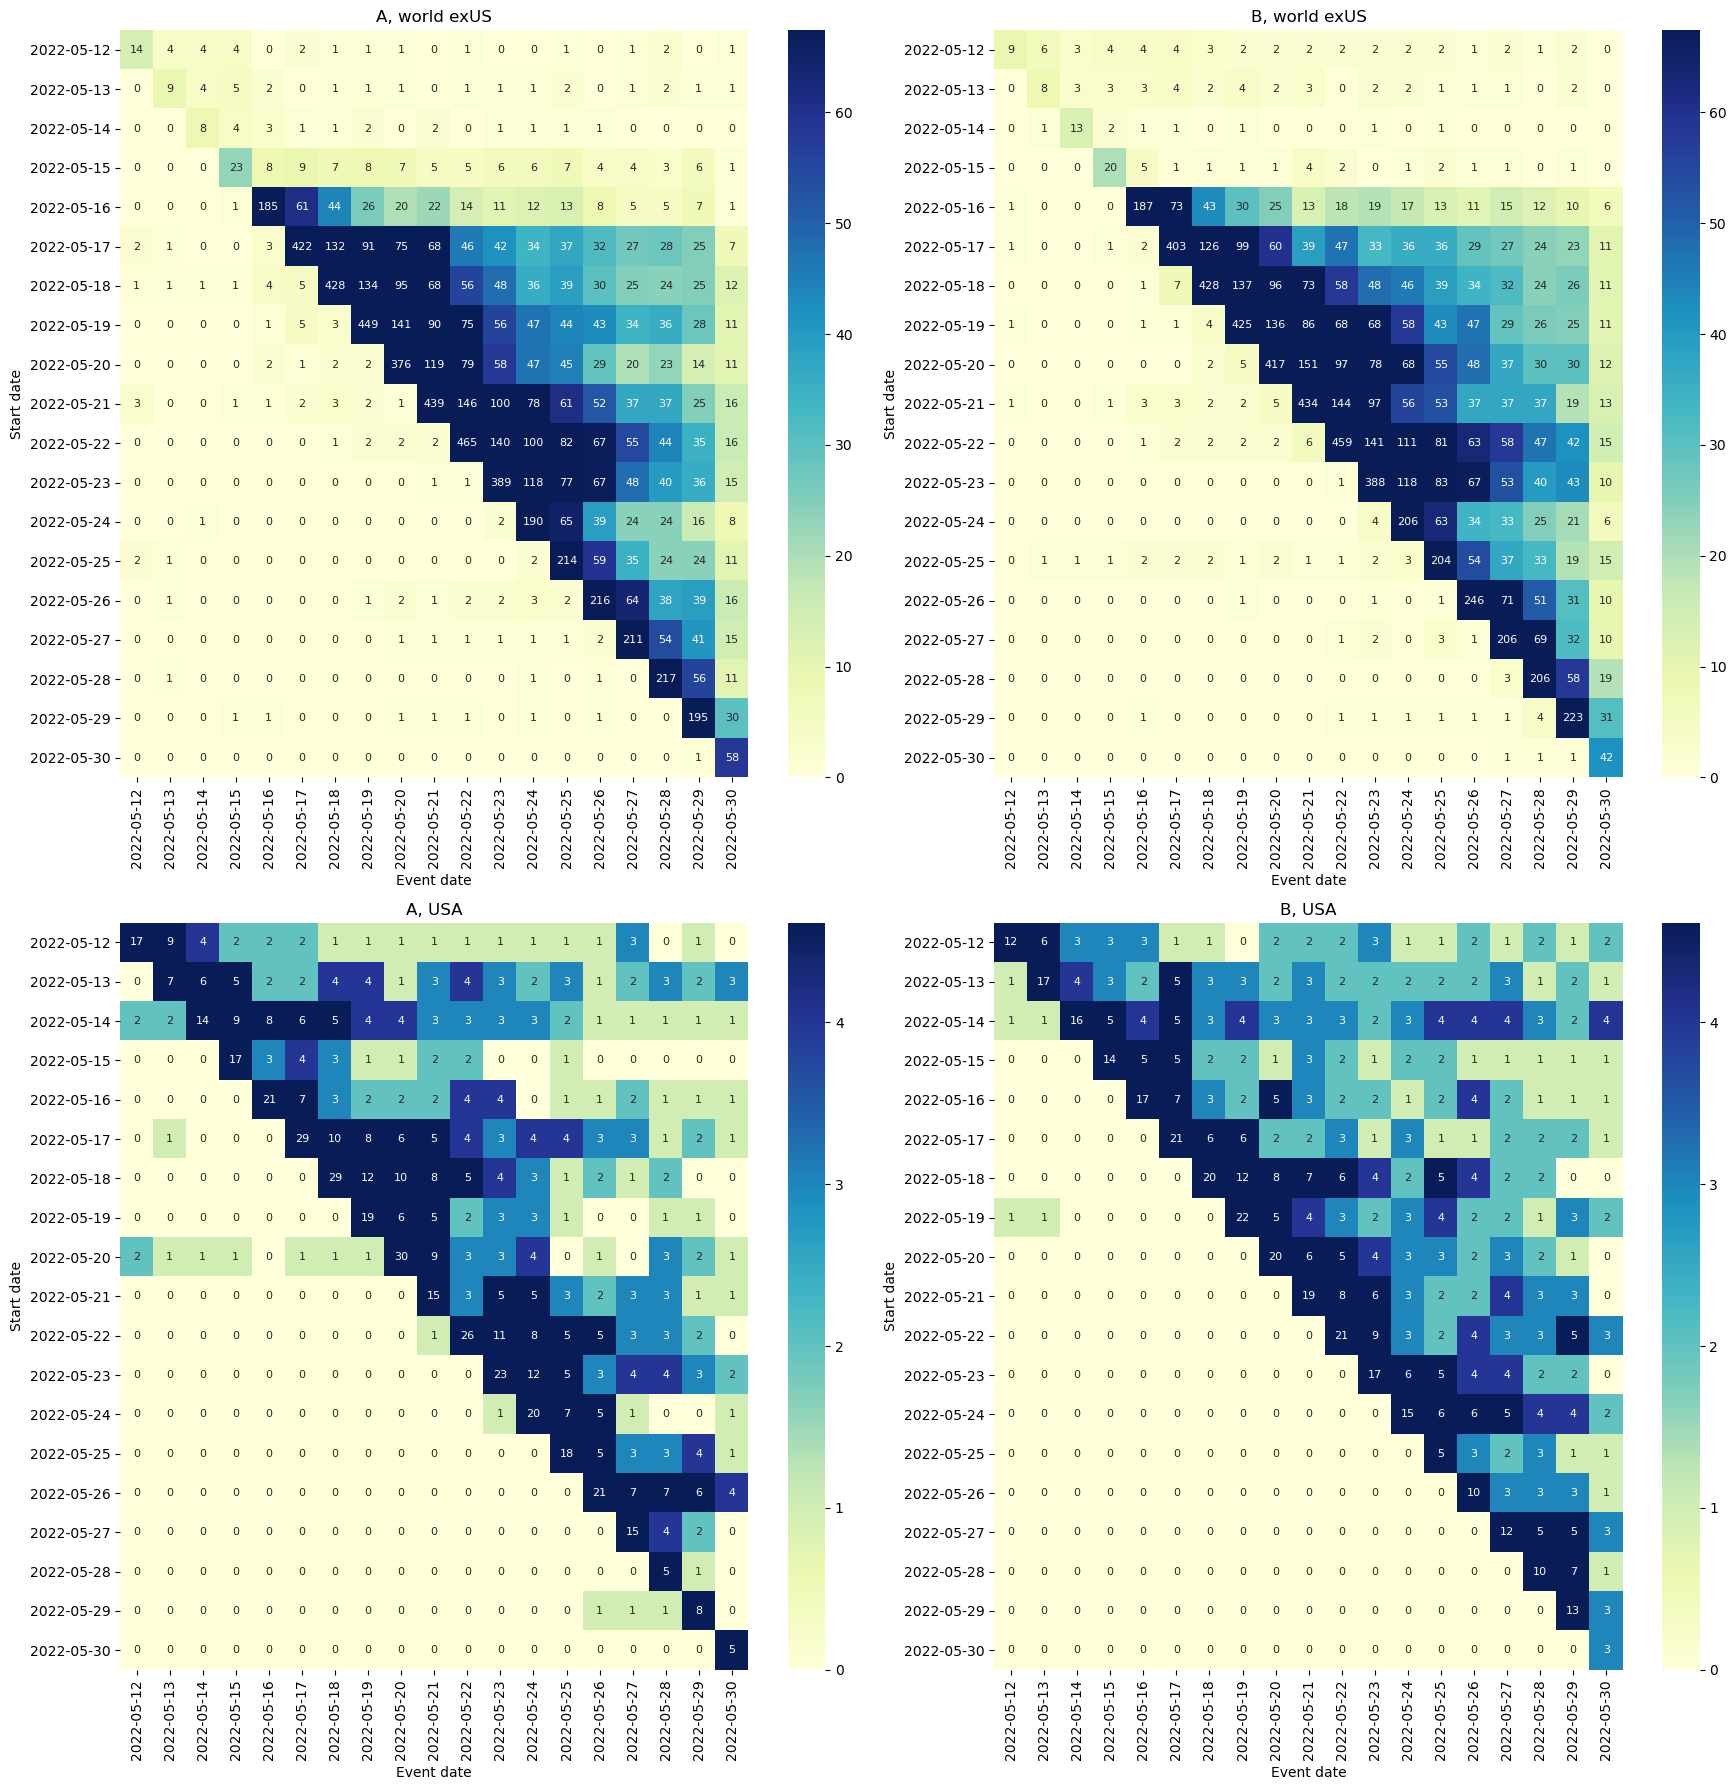

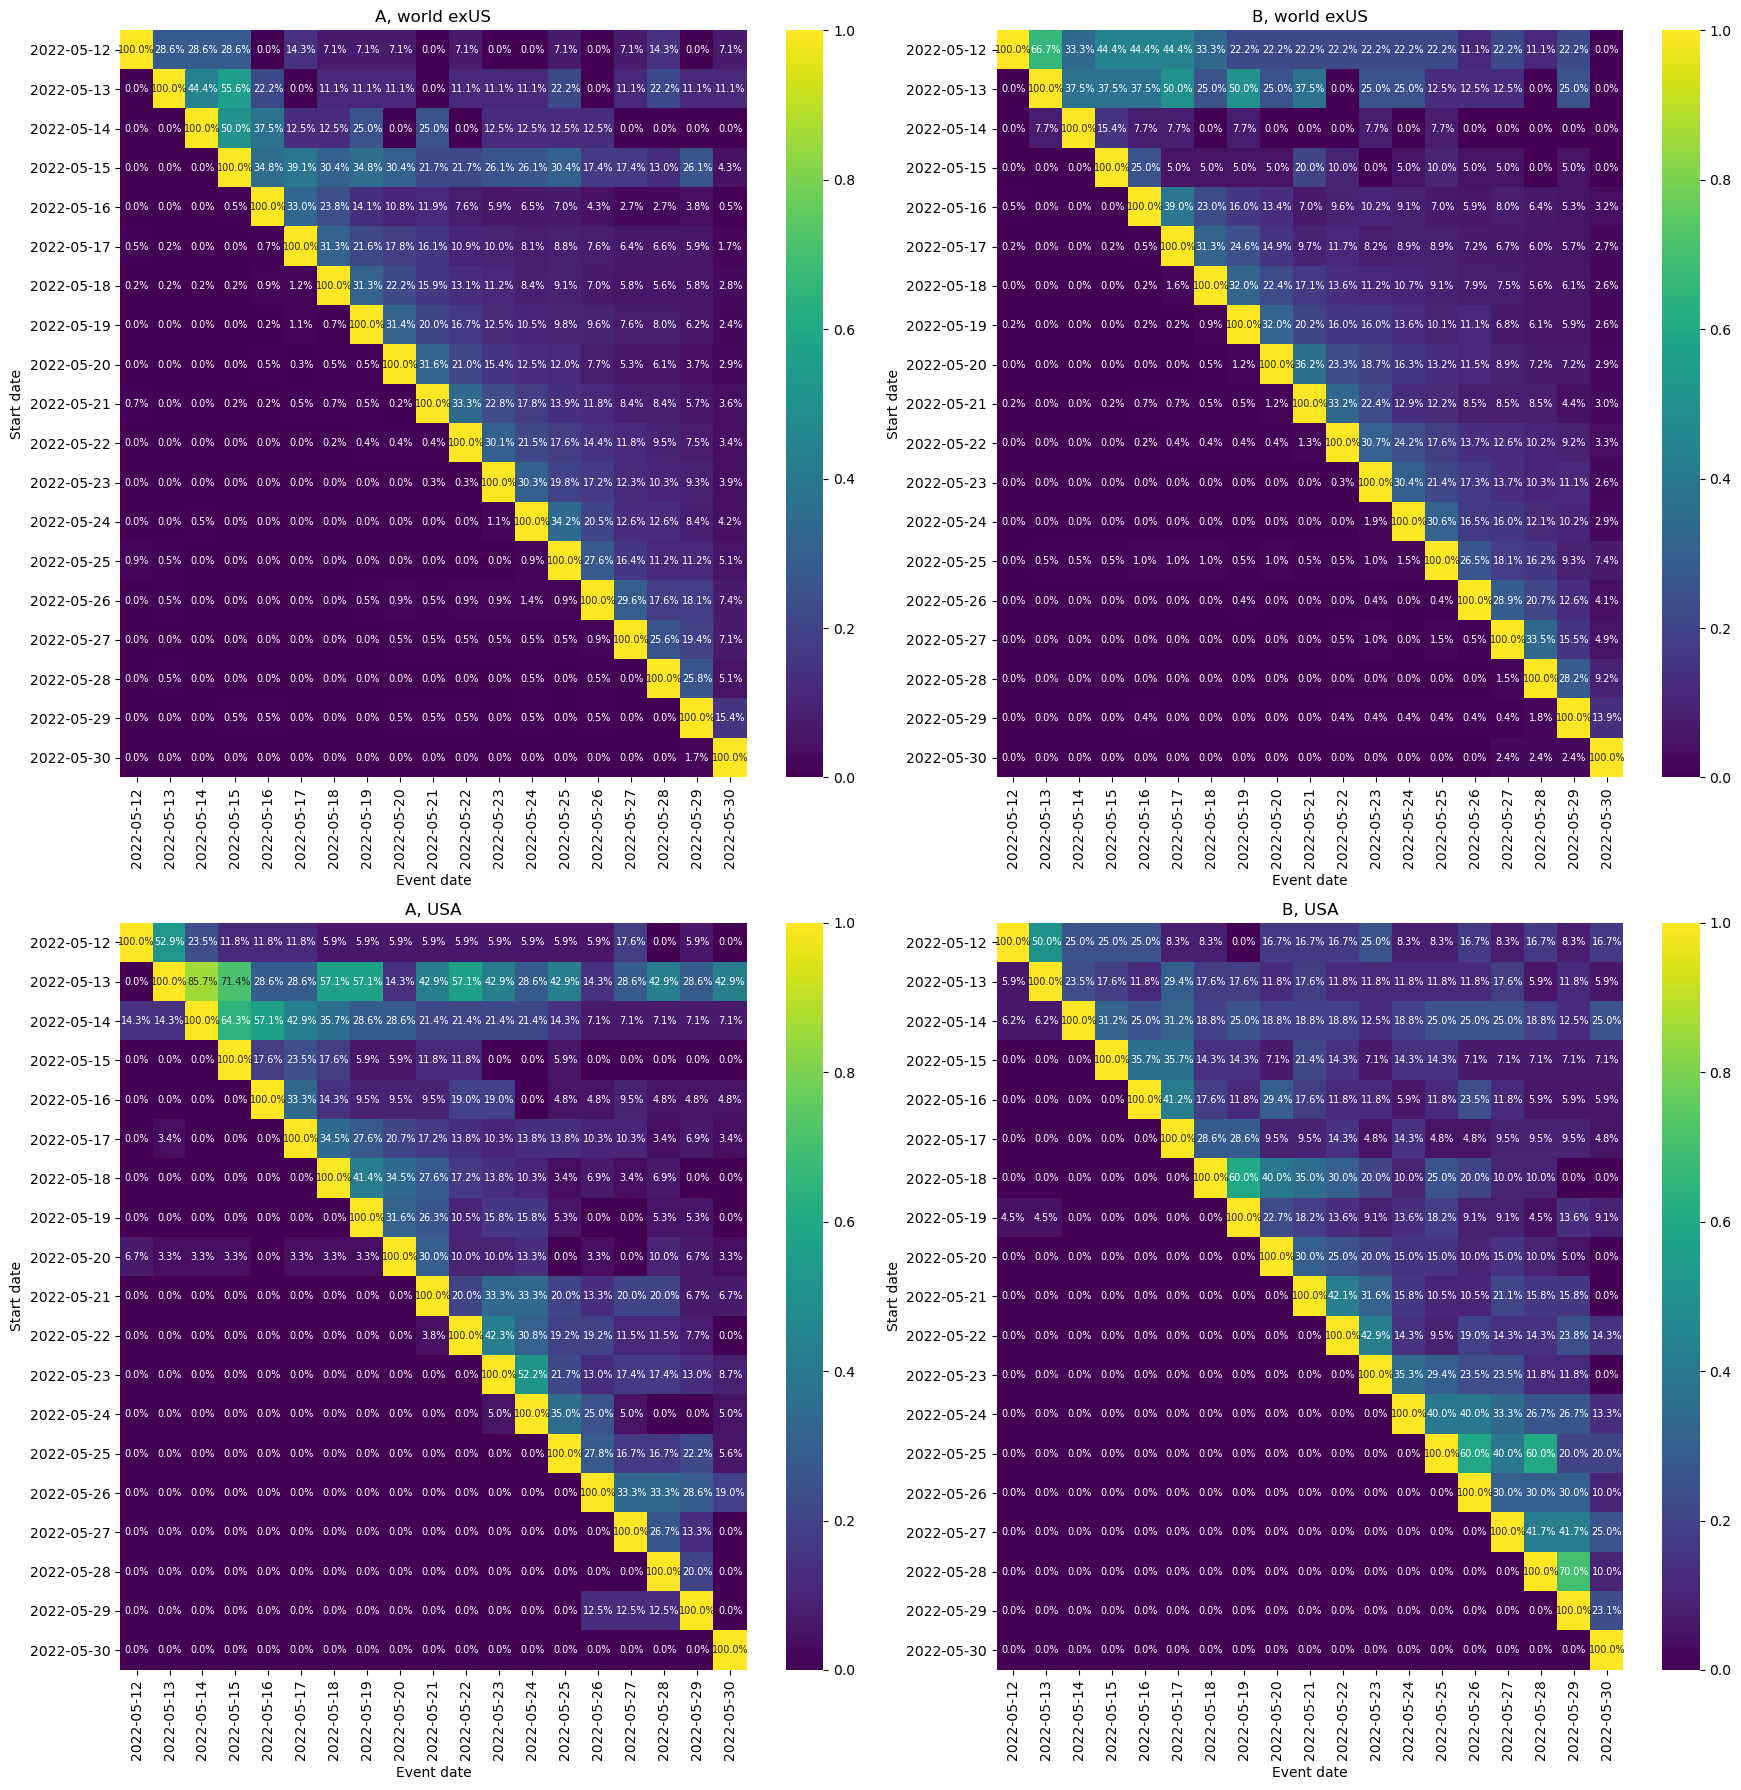

In [473]:
labels = ['A, world exUS', 'B, world exUS', 'A, USA', 'B, USA']
plot_4_heat maps(hm_others_a, hm_others_b, hm_exception_a, hm_exception_b, normal=False, labels=labels)
plot_4_heat maps(hm_others_a, hm_others_b, hm_exception_a, hm_exception_b, normal=True, labels=labels)

### Plot the differences by heat map in Samsung group <a class="anchor" id="hm_sam_diff"></a>

<b>Absolute values</b>

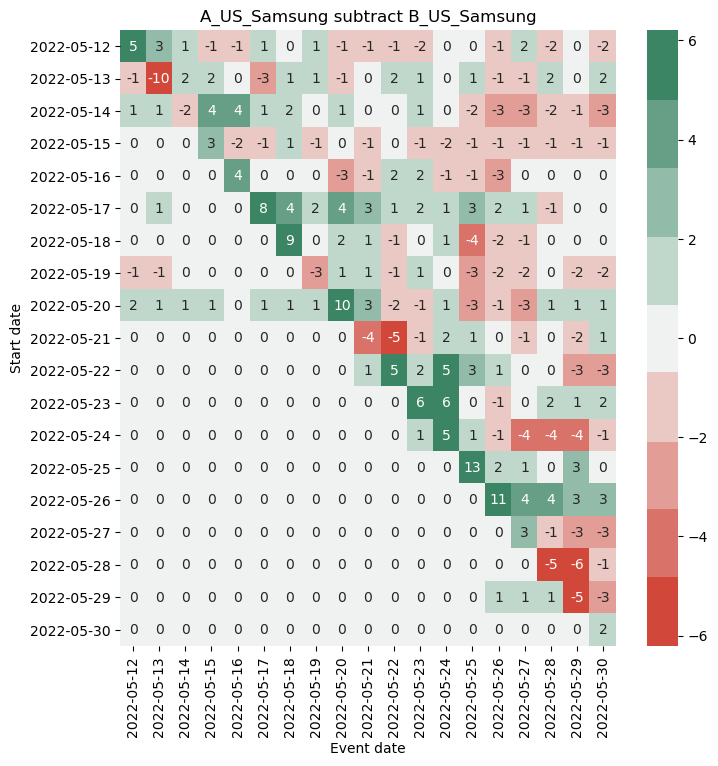

In [474]:
# absolute difference
label = 'A_US_Samsung subtract B_US_Samsung'
plot_diff_heat maps(hm_exception_a, hm_exception_b, normal=False, label=label) # Label None for test

<i>The color scale adjusted by one sigma limit</i>

<b>Normalized values</b>

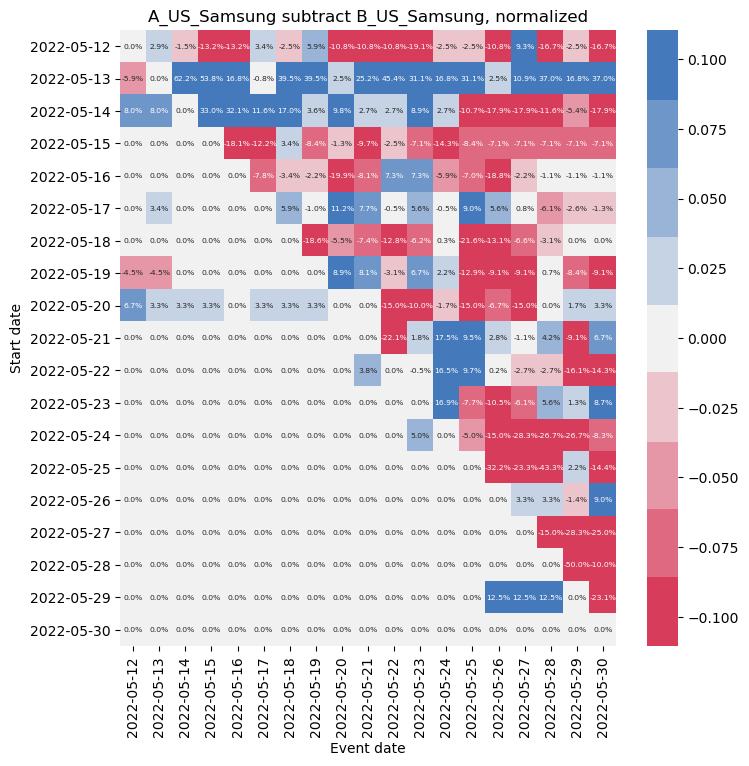

In [475]:
# difference of normalized tables
label = 'A_US_Samsung subtract B_US_Samsung'
plot_diff_heat maps(hm_exception_a, hm_exception_b, normal=True, label=label) # Label None for test

<i>The color scale adjusted by one sigma limit</i>

### Conclusion <a class="anchor" id="5_conc"></a>
We still have more users with old app (A) in Samsung group, and total numbers here are not enough to get clear trends.<br>
Generally in doesn't look much different from a larger group, so we are going to conclude that there is no significant difference between the groups we observed

# General conclusion <a class="anchor" id="gen_conc"></a>
There is no significant difference between groups, and there are the good news - the new app version working properly and we can to allow to all new users migrating there. We found no deviations in the groups, large regions and popular devices have a full functionality. Great!

# Next steps <a class="anchor" id="next"></a>
The next step could be to find the better way to choose the groups to compare. Maybe by multynomial regression or some clusterisation we can get most different groups to explore and find small, but important subgroups.